# Machine Learning: Fundamentals and Architectures

*Created by Jason Stock, Aug 2024*

This notebook is a non-exhaustive overview of modeling techniques for different data modalities, including **tabular**, **image**, and **time series** data. We will cover methods to find weights for a linear model with gradient descent to image translation and autoregressive forecasting. Within each section are examples applied to toy problems and synthetic data. This is just to serve as an example with little computational overhead. However, the code is modular and templeted so that it can be applied to other datasets.

To get the most out of this tutorial, we assume the reader has moderate Python experience and some background in calculus and linear algebra. Some materials are adapted from those originally created by [Prof. Chuck Anderson](https://www.cs.colostate.edu/~anderson/wp/). Other examples are referenced and linked to throughout the notebook. *Some code is reused in the notebook and it is advised to run the notebook from the first cell.*

In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from typing import List, Union

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import os
import sys
import contextlib

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

COLORS = ['#1b9e77', '#d95f02', '#7570b3']  # teal, orange, purple
DATA_DIR = '~/d4-mldata'

## Tabular

Data of this form are typically represented in a table, where each row is a sample with $n > 0$ input features $\mathbf{x}$ and $m \ge 0$ target features or classes $\mathbf{t}$. The table below shows a general form.

| $x_1$ | $x_2$ | ... | $x_n$ | $t_1$ | $t_2$ | ... | $t_m$ |
|:-----:|:-----:|:---:|:-----:|:-----:|:-----:|:---:|:-----:|
|  0.1  |  0.2  | ... |  0.9  |  1.0  |  1.1  | ... |  1.8  |
|  0.3  |  0.4  | ... |  1.0  |  1.2  |  1.3  | ... |  1.9  |
|  ...  |  ...  | ... |  ...  |  ...  |  ...  | ... |  ...  |
|  0.5  |  0.6  | ... |  1.2  |  1.4  |  1.5  | ... |  2.0  |

Let's use an existing dataset as a running example throughout this section! The California Housing dataset introduced in [Sparse Spatial Autoregressions](https://www.sciencedirect.com/science/article/abs/pii/S016771529600140X) by R. Kelley Pace and Ronald Barry (1997) will work well.

The data is sourced from the 1990 US census, with each row representing a census block group. This is the smallest geographic area for which the US Census Bureau provides sample data -- typically with 600 to 3,000 people. We aim to model the median house value for districts in California, presented in units of \$100,000. The independent varibles include median income, median house age, average household members, among others. [scikit-Learn](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) has a nice API to download the data, where we can then inspect the feature names and data shape.

> **GOAL**: predict **median house value** from median income, median house age, average household members, etc.

In [2]:
housing = fetch_california_housing(data_home=DATA_DIR)
print(f'{housing.feature_names=}')
print(f'{housing.target_names=}\n')

X = housing.data
T = housing.target.reshape(-1, 1)
print(f'{X.shape=}, {T.shape=}')

housing.feature_names=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
housing.target_names=['MedHouseVal']

X.shape=(20640, 8), T.shape=(20640, 1)


There are 20,640 samples with 8 input features and 1 target features. The magnitude of features are not very uniform, so let's z-score normalize the input to have zero mean and unit variance. The targets are kept in their original units.

In [3]:
# standardize X
X = (X - X.mean(axis=0)) / X.std(axis=0)

The `partition` function will help us split the data into training and test data by randomly sampling a portion of samples. Typically, we use 80% for training and 20% for testing, maintaining the input-target relationship. We partition the data to ensure that our model is trained on a diverse subset while being evaluated on unseen samples, helping us gauge its performance on new data. By maintaining a consistent split, we can compare results across different models or experiments.


```{note}
*While random splits are commonly used, they may not always be the best choice depending on the nature of the data. For instance, in time series or spatial data, random splits could lead to autocorrelation issues, where training and test sets are not truly independent. In such cases, it’s often better to use methods like time-based splits or other techniques that account for these dependencies.*
```

In [5]:
def partition(X: np.ndarray, T: np.ndarray,
              train_fraction: float, validation_fraction: float = 0, 
              shuffle: bool = False, seed: int = 1234) -> Union[List[np.ndarray], List[np.ndarray]]:
    if shuffle:
        rng = np.random.default_rng(seed)
        indices = rng.permutation(X.shape[0])
        X, T = X[indices], T[indices]
    
    train_end = int(X.shape[0] * train_fraction)

    if validation_fraction > 0:
        valid_end = train_end + int(X.shape[0] * validation_fraction)
        Xtrain, Xvalid, Xtest = X[:train_end], X[train_end:valid_end], X[valid_end:]
        Ttrain, Tvalid, Ttest = T[:train_end], T[train_end:valid_end], T[valid_end:]
        return Xtrain, Ttrain, Xvalid, Tvalid, Xtest, Ttest
    else:
        Xtrain, Xtest = X[:train_end], X[train_end:]
        Ttrain, Ttest = T[:train_end], T[train_end:]
        return Xtrain, Ttrain, Xtest, Ttest
    
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8, shuffle=True, seed=42)
print(f'{Xtrain.shape=}, {Ttrain.shape=}, {Xtest.shape=}, {Ttest.shape=}')

Xtrain.shape=(16512, 8), Ttrain.shape=(16512, 1), Xtest.shape=(4128, 8), Ttest.shape=(4128, 1)


We will evaluate our models using *root-mean-squared error* (RMSE) and *coefficient of determination* ($\text{R}^2$) with the helper functions below. The `plot_evaluation` function will show a simple regression analysis along with the RMSE and $\text{R}^2$. 

These will come in handy soon...

In [6]:
def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

def r2(T, Y):
    ss_res = np.sum((T - Y) ** 2)
    ss_tot = np.sum((T - np.mean(T)) ** 2)
    return 1 - (ss_res / ss_tot)

# !plotting
def plot_evaluation(T, Y):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.plot(T, Y, 'o', alpha=0.20, markersize=3, color='k')
    ax.plot([T.min(), T.max()], [T.min(), T.max()], 'b', lw=2.5)
    ax.set_xlabel('True Price (hundreds of thousands USD)')
    ax.set_ylabel('Predicted Price')
    ax.set_title(f'RMSE: {rmse(T, Y):.3f}, R$^2$: {r2(T, Y):.3f}', loc='right')
    fig.tight_layout()

### Polynomial Regression with Gradient Descent

Let's start with modeling a set of data points with a linear model, $f(\mathbf{x}; \mathbf{w})$, a function of $\mathbf{x}$ that is parameterized by a weight vector $\mathbf{w} = (w_0, w_1, w_2, \ldots, w_d)$,

\begin{align*}
  f(\mathbf{x}; \mathbf{w}) = w_0 + w_1 x_1 + \dots + w_d x_{d} = \mathbf{x}_i^\top \mathbf{w}
\end{align*}

Given a collection of samples of $\mathbf{x}$ and target values of $f(\mathbf{x})$, how we do pick our weights $\mathbf{w}$? The best values of $\mathbf{w}$ should have $f(\mathbf{x}; \mathbf{w})$ "close to" their targets. A common method is to *minimize the squared error* between the predicted value and its target $t_i$,

$$
  \mathbf{w}_\text{best} = \arg\min_{\mathbf{w}} \sum_{i=1}^n (t_i - \mathbf{x}_i^\top \mathbf{w})^2
$$

One method to solve this is with **gradient descent**, a sequential algorithm for finding $\mathbf{w}$ by taking a small step scaled by $\eta$ in the negative direction of the function's derivative,

$$
  \mathbf{w}^{(k+1)} = \mathbf{w}^{(k)} - \eta \frac{\partial E} {\partial \mathbf{w}}
$$

```{note}
*A majority of the methods throughout this notebook, and in machine learning more generally, rely on gradient descent. Often times, this is hidden or abstracted away, which is why we are deriving it.*
```

Here, we use the fact that a derivative of a sum is the sum of the derivatives,

\begin{align*}
  \frac{\partial \sum_{i=1}^n (t_i - \mathbf{x}_i^\top \mathbf{w})^2}{\partial \mathbf{w}} 
  &= \sum_{i=1}^n \frac{\partial (t_i - \mathbf{x}_i^\top \mathbf{w})^2}{\partial \mathbf{w}}\\
  &= \sum_{i=1}^n 2 (t_i - \mathbf{x}_i^\top  \mathbf{w}) (-1) \mathbf{x}_i\\
  &= -2 \sum_{i=1}^n (t_i - \mathbf{x}_i^\top  \mathbf{w}) \mathbf{x}_i\\
\end{align*}

In a *stochastic* setting, we can update our weights $\mathbf{w}$ after each sample without the summation. Now, subsituting the derivative into our weight update funciton, we have

$$
\mathbf{w}^{(k+1)} = \mathbf{w}^{(k)} - \eta (-2) (t_i - \mathbf{x}_i^\top  \mathbf{w}) \mathbf{x}_i
$$

However, in a general form that does not using minibatches of data, the update rule can be applied directly across all samples. Consider the input $\mathbf{X}$, weights (with a bias term) $\mathbf{W}$, and target values $\mathbf{T}$,

$$
\mathbf{X} = \begin{bmatrix} x_{1,1} & x_{1,2} & \dots & x_{1,d} \\ x_{2,1} & x_{2,2} & \dots & x_{2,d} \\ \vdots & \vdots & \ddots & \vdots \\ x_{n,1} & x_{n,2} & \dots & x_{n,d} \end{bmatrix}, \quad
\mathbf{W} = \begin{bmatrix} w_0 \\ w_1 \\ \vdots \\ w_d \end{bmatrix}, \quad
\mathbf{T} = \begin{bmatrix} t_1 \\ t_2 \\ \vdots \\ t_n \end{bmatrix}
$$

We can now define a general matrix form for our forward pass and sequential update rule,
\begin{align*}
\mathbf{Y} &= \mathbf{W}_{0} + \mathbf{X}\mathbf{W}_{1:}\\
\mathbf{W}^{(k+1)} &= \mathbf{W}^{(k)} - \eta\frac{(-2)}{n} \mathbf{X}^\top (\mathbf{T} - \mathbf{Y})
\end{align*}

Now, let's write this in Python!

In [7]:
def model(X, W):
    return W[0] + X @ W[1:]

def gradient_f(X, T, W):
    Y = model(X, W)
    dEdY = -2 * (T - Y)
    dYdW = np.insert(X, 0, 1, axis=1) # column of ones for bias
    return dYdW.T @ dEdY / X.shape[0]

def gradient_descent(X, T, W, eta, epochs):
    error_trace = []
    W_trace = []
    for _ in range(epochs):
        Y = model(X, W) # forward pass

        error_trace.append(rmse(T, Y))
        W_trace.append(W.flatten())
        
        W -= eta * gradient_f(X, T, W) # entire update rule!
        
    return W, error_trace, W_trace

Great! We have our `model`, the function's `gradient_f` for the *mean squared error*, and `gradient_descent` optimization algorithm to find our values of $\mathbf{W}$. Let's initialize our weights to be all zeros, define the learning rate $\eta$, and the number of training iterations. 

In [8]:
W = np.zeros((Xtrain.shape[1] + 1, 1))

eta = 0.01
epochs = 200

W, error_trace, W_trace = gradient_descent(Xtrain, Ttrain, W, eta, epochs)

Our model has finished training!

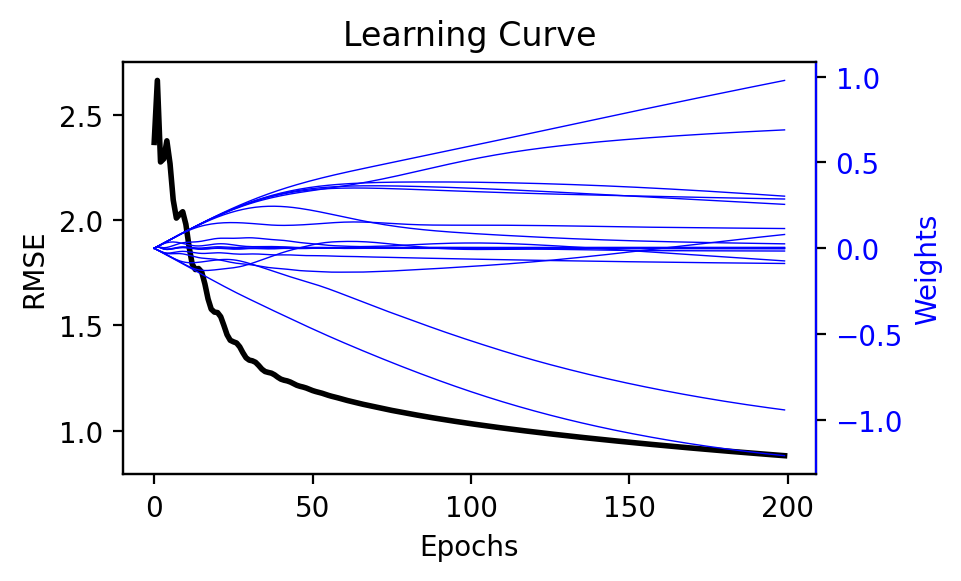

In [15]:
# !plotting
def plot_trace(error_trace, W_trace):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ax.plot(error_trace, 'k', lw=2)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('RMSE')
    ax.set_title('Learning Curve');
    ax2 = ax.twinx()
    ax2.plot(W_trace, 'b', lw=0.5)
    ax2.set_ylabel('Weights', color='b')
    for tl in ax2.get_yticklabels():
        tl.set_color('b')
    ax2.spines['right'].set_color('b')
    fig.tight_layout()

plot_trace(error_trace, W_trace)

We visualize how the error decreases and weights change during training with `plot_trace`. The error (in black) decreases toward zero and eventually plateaus as the number of iterations increase. Similarly, the weights (in blue) appear to converge. Because the model is linear, we could inspect these weights to help provide an intuition as to what features have the greatest influence on the prediction.

`````{admonition} Question
*How well does this model perform **on the test data**?*
`````

Let's do a forward pass of our model to generate predictions for each sample, $y_i = f(\mathbf{x}; \mathbf{w})$, and compare them to each target $t_i$. Use the `plot_evaluation` function to summarize the result in the figure below.

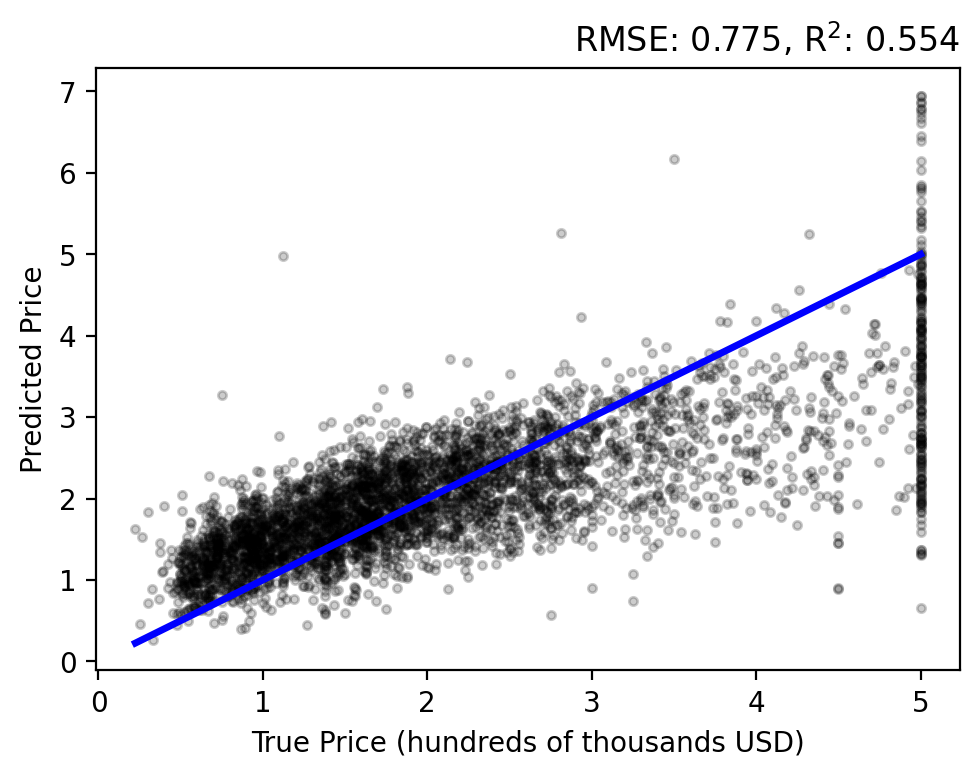

In [9]:
Ytest = model(Xtest, W)
plot_evaluation(Ttest, Ytest)

The regression analysis shows the target vs predicted values with the RMSE and $\text{R}^2$ in the title. A perfect fit would follow the linear, blue line and have zero error and a unit coefficient. Our linear model performs *okay*, but over estimates lower prices while under estimating higher prices and never capturing the upper bound of true values.

`````{admonition} Question
*What if we add a **slight amount of nonlinearity**?*
`````

Polynomial regression adds a power component to each (*or some*) of the independent variables,

$$
f(\mathbf{x}; \mathbf{w}) = w_0 + w_1 x_1 + w_2 x_1^2 + \dots + w_n x_d^p 
$$

Let's define a quadratic model by modifying our input data to have a squared component. 

In [10]:
max_degree = 2
Xtrain_poly = np.hstack([Xtrain**i for i in range(1, max_degree + 1)])
Xtest_poly = np.hstack([Xtest**i for i in range(1, max_degree + 1)])
print(f'{Xtrain_poly.shape=}, {Xtest_poly.shape=}')

Xtrain_poly.shape=(16512, 16), Xtest_poly.shape=(4128, 16)


Before we train our model, let's use an improved optimization algorithm to traditional gradient descent known as adaptive moment estimation, [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) by Diederik P. Kingma and Jimmy Lei Ba. Folowing this work, and starting with our `gradient_descent` function, let's add a few additional momentum terms to properly scale the gradient and stabilize training.

In [13]:
def adam(X, T, W, eta, epochs):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    m = 0
    v = 0
    
    error_trace = []
    W_trace = []
    for step in range(epochs):
        Y = model(X, W) # forward pass
        
        error_trace.append(rmse(T, Y))
        W_trace.append(W.flatten())
        
        g = gradient_f(X, T, W) # gradient
        
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g * g
        mhat = m / (1 - beta1 ** (step+1))
        vhat = v / (1 - beta2 ** (step+1))
        
        W -= eta * mhat / (np.sqrt(vhat) + epsilon) # new update rule!
        
    return W, error_trace, W_trace

:::{seealso}
We have now seen **gradient decent** and **Adam**, but there are many other algorithms that are supported by a rich amount of literature. See [A Comparison of Optimization Algorithms for Deep Learning](https://arxiv.org/abs/2007.14166) by Derya Soydaner for mode details.
:::

Let's use Adam to optimize our quadratic model!

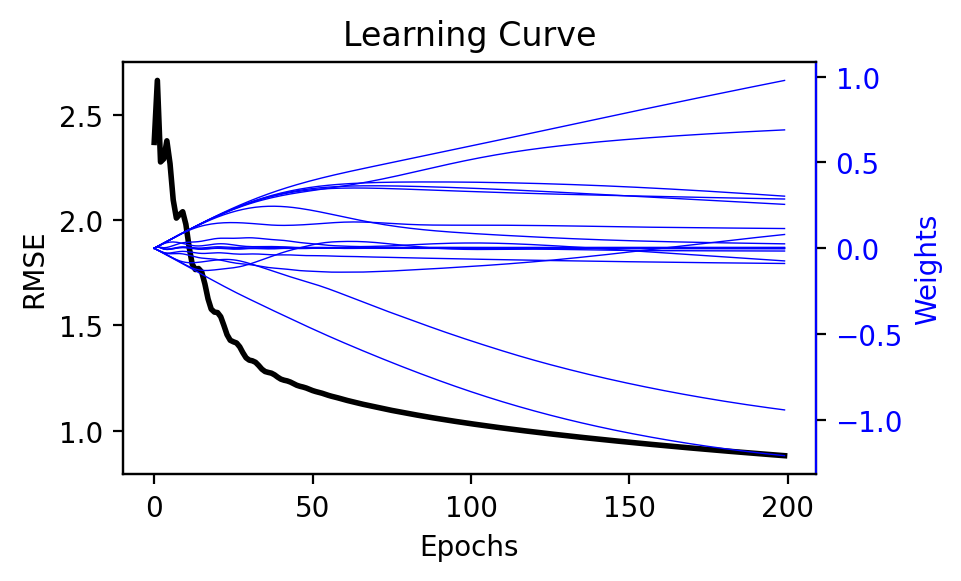

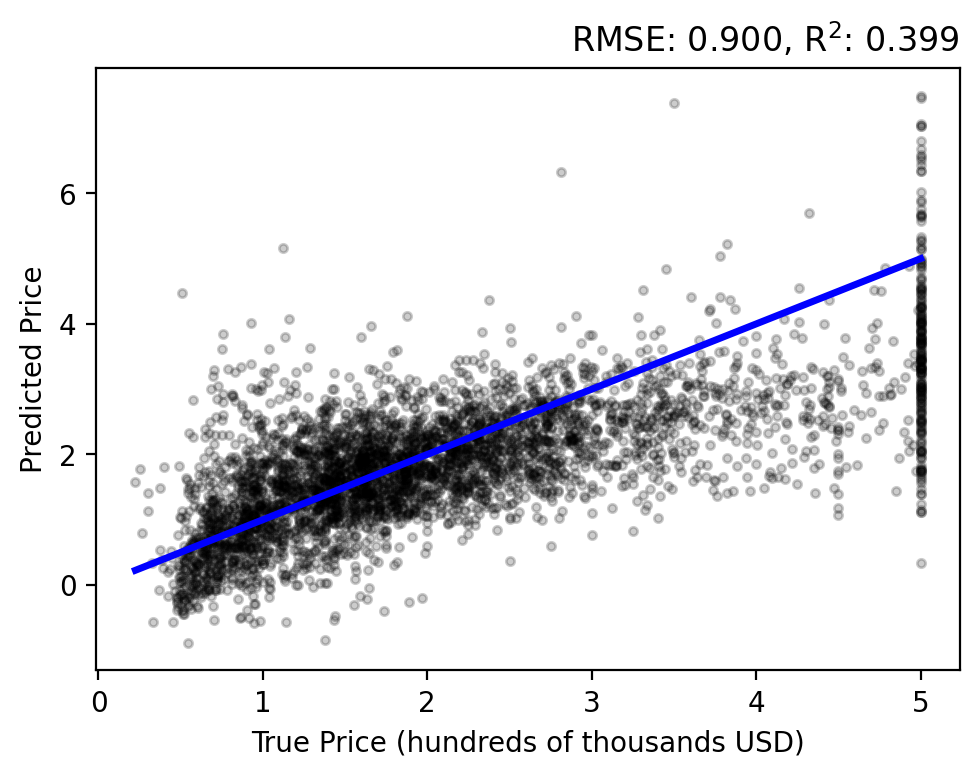

In [16]:
W = np.zeros(Xtrain_poly.shape[1] + 1).reshape(-1, 1)

eta = 0.01
epochs = 200

W, error_trace, W_trace = adam(Xtrain_poly, Ttrain, W, eta, epochs)

plot_trace(error_trace, W_trace)
Ytest = model(Xtest_poly, W)
plot_evaluation(Ttest, Ytest)

### Random Forest

What if we combined multiple models instead of just one? A random forest does this by combining multiple *decision trees* to improve prediction accuracy. Each tree is trained on a random subset of the data, and their predictions are averaged (for regression) or voted on (for classification) to make the final decision. The process does not involve iterative optimization like gradient descent; rather, it relies on the greedy selection of splits at each node of the trees. {numref}`random-forest-im` illustrates just this!

:::{figure-md} random-forest-im
<img src="../../img/machine-learning/random_forest.png" alt="random-forest-im" width="500px">

The random forest model from ([Medium](https://medium.com/@roiyeho/random-forests-98892261dc49)).
:::

Random forests are quiet efficient, while being more robust to outliers and noise than linear regression. Give the final prediction is from an ensemble of trees, the model can capture complex, nonlinear relationships.

:::{seealso}
Additional references:
- [The Random Forest Algorithm](https://mlu-explain.github.io/random-forest/)
- [Decision Trees](https://mlu-explain.github.io/decision-tree/)
:::

Let's start with getting our data once again!

In [17]:
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8, shuffle=True, seed=42)

Ttrain = Ttrain.ravel()
Ttest = Ttest.ravel()
print(f'{Xtrain.shape=}, {Ttrain.shape=}, {Xtest.shape=}, {Ttest.shape=}')

Xtrain.shape=(16512, 8), Ttrain.shape=(16512,), Xtest.shape=(4128, 8), Ttest.shape=(4128,)


For simplicity, we are going to use the `RandomForestRegressor` implementation from `scikit-learn`. We define a handful of the parameters below. Try adjusting these to see how it impacts performance.

In [18]:
params = {
    'n_estimators': 20,      # number of trees in the forest
    'max_depth': 5,          # maximum depth of each tree
    'min_samples_split': 2,   # minimum number of samples required to split an internal node
    'min_samples_leaf': 1,    # minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',   # number of features to consider when looking for the best split
    'bootstrap': True,        # whether bootstrap samples are used when building trees
    'random_state': 42,       # seed for reproducibility
    'n_jobs': -1              # use all available cores for parallel processing
}

model = RandomForestRegressor(**params)
model.fit(Xtrain, Ttrain);

Evaluating the results on the test set... there is a stronger correlation between the true and predicted prices, relative to our previous methods. However, we still have an overestimation bias and an inability to capture high-valued outliers.

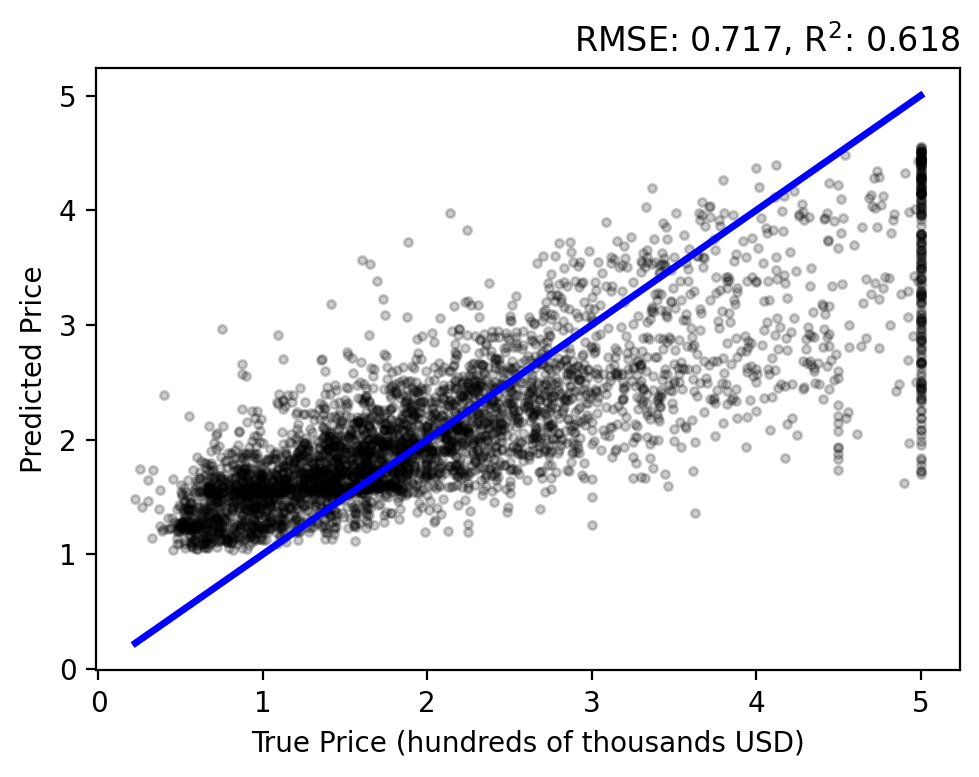

In [19]:
Ytest = model.predict(Xtest)
plot_evaluation(Ttest, Ytest)

`````{admonition} Question
***What features are important** for inferring a prediction?*
`````

With our linear model, we could simply look at the weights to see how a unit change in some feature influences the model's prediction. To achieve a similar explanation for our random forest, we can use permutation importance. This measures the impact of shuffling each feature on the model’s accuracy, allowing us to identify which features are most influential. 

In the figure below, features like `MedInc` and `Latitude` have the highest importance, indicating that they influence the model’s predictions more significantly. 

/var/folders/3n/pbnqdsys6ks6vhbbbd4j1ftwfpsfpx/T/ipykernel_96960/3467066378.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


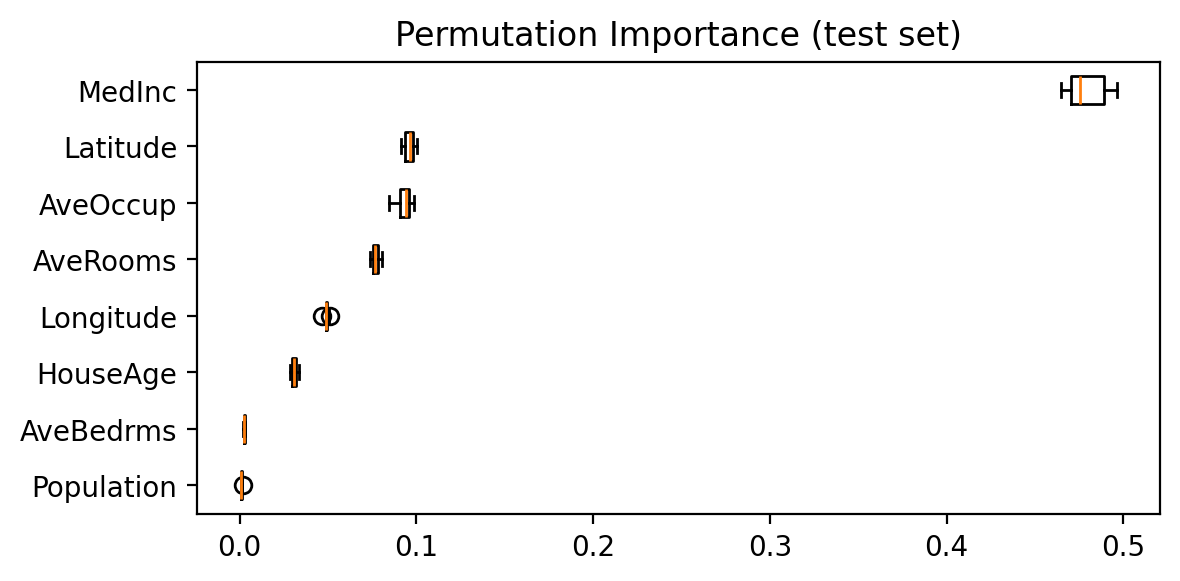

In [20]:
result = permutation_importance(
    model, Xtest, Ttest, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_idx = np.argsort(result.importances_mean)

fig, ax = plt.subplots(figsize=(6, 3))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(housing.feature_names)[sorted_idx],
)
ax.set_title('Permutation Importance (test set)')
fig.tight_layout()

```{note}
Permutation importance can be applied to a large range of models, not just random forests!
```

### Gradient Boosting

Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions, introduced in [Friedman (2001)](https://projecteuclid.org/journals/annals-of-statistics/volume-29/issue-5/Greedy-function-approximation-A-gradient-boosting-machine/10.1214/aos/1013203451.full). GBDT can be used for both classification and regression, particularlly suited to tabular data. We focus on the case for regression, which builds an additive model in a forward stage-wise fashion. In each stage a regression tree is fit on the current residuals with the negative gradient of the error function.

:::{figure-md} gradient-boosting-im
<img src="../../img/machine-learning/gradientboost.png" alt="gradient-boosting-im" width="600px">

The architecture of Gradient Boosting Decision Tree ([Deng et al. (2021)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8638201/#:~:text=It%20indicated%20that%20the%20ensemble,information%20and%20might%20even%20worsen.)).
:::

The above figure illustrates these steps at a high level. Each model is a weak approximation of the target data, where the residual of predictions are then estimated by the next step -- essentially creating an ensemble. The final output is estimated by accumulating the predictions across each tree.

Let's start with getting our training and test splits again...

In [21]:
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8, shuffle=True, seed=42)

Ttrain = Ttrain.ravel()
Ttest = Ttest.ravel()
print(f'{Xtrain.shape=}, {Ttrain.shape=}, {Xtest.shape=}, {Ttest.shape=}')

Xtrain.shape=(16512, 8), Ttrain.shape=(16512,), Xtest.shape=(4128, 8), Ttest.shape=(4128,)


Let's use sklearn's [`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) and define a subset of parameters to fit out data. For a full list of parameters, take a look at the documentation. 

With just a couple lines of code we can fit our model!

In [22]:
params = {
    'n_estimators': 100,      # number of boosting stages to perform
    'learning_rate': 0.05,    # step size shrinkage
    'max_depth': 4,           # maximum depth of the individual estimators
    'min_samples_split': 10,  # minimum number of samples required to split an internal node
    'min_samples_leaf': 2,    # minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',   # number of features to consider when looking for the best split
    'subsample': 0.8,         # fraction of samples to be used for fitting the individual base learners
    'random_state': 42        # seed for reproducibility
}
model = GradientBoostingRegressor(**params)
model.fit(Xtrain, Ttrain);

Now, evalaute the model on the test data...

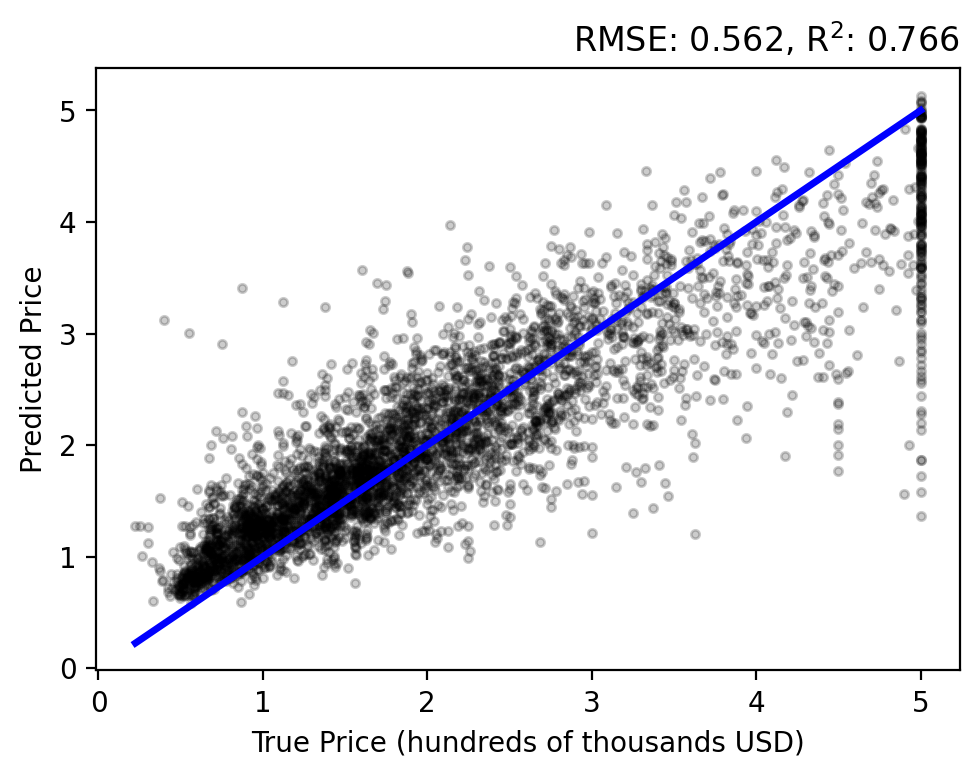

In [23]:
Ytest = model.predict(Xtest)
plot_evaluation(Ttest, Ytest)

As with the Random Forest, the results are better distributed around zero error, with a slight bias toward over predicting. However, the error and coefficient of determination are greater than all of the models we have seen yet.

### Fully Connected Neural Networks

The structure of a neural network extends on the intuition of linear regression that we derived earlier. However, instead of just a singular weighted sum of our input, we perform a *nonlinear combination of inputs*. Ultimately, we want to find a function $ f_{\theta}: x \mapsto y $ that best approximates the relationship between our inputs $x$ and the desired outputs $y$, where $\theta$ represents the learned parameters of the model. 

{numref}`nnet01` illustrates this, where we have $n$ <span style="color: darkgreen;">input features</span> (i.e., $\mathbf{x}_i \in \mathbb{R}^{1\times n}$), three <span style="color: darkblue;">hidden layers </span> with $m$ units each, and $k$ <span style="color: darkred;">output features </span> (i.e., $\mathbf{t}_i,\mathbf{y}_i \in \mathbb{R}^{1\times k}$). The flow of data starts from the input and moves *forward* through the network to the output. The number of hidden layers and units are arbitrarily chosen for visualization. In fact, we can have any number of layers and units between the input and output. Let's define a standard vector notation to specify these values. For example, `[16, 8, 4]` is a three layer network with 18 units in the first hidden layer, 8 units in the second, and 4 in the last.

:::{figure-md} nnet01
<img src="../../img/machine-learning/neural_networks-001.png" alt="nnet01" width="500px">

Fully-connected neural network ([TikZ](https://tikz.net/neural_networks/)).
:::

`````{admonition} Question
*What exactly is a **hidden layer** and **unit**?*
`````

{numref}`nnet02` highlights the computation of a single unit, and is summarized with the following steps: 
1. Gather input from the output of all units in the previous layer (or input features if at the first hidden layer)
2. Do a weighted sum of the input with weights and bias in that unit
3. Perform a nonlinear transformation of the weighted sum with some function $\sigma$

Steps 1-3 are preformed with all units in parallel for a given layer (using some linear algebra and matrix notation). Thereafter, the computation proceeds to the next layer until we have an output prediction.

:::{figure-md} nnet02
<img src="../../img/machine-learning/neural_networks-002.png" alt="nnet02" width="650px">

Computation of a single hidden unit ([TikZ](https://tikz.net/neural_networks/)).
:::

The activation $\sigma$ is a differentiable nonlinear function. There are [many different](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) activations that we often chosen based on the underlying data (often empirically). The `get_activation` will allow us to experiment with different activations, and the following figure shows a domain of some popular activations.

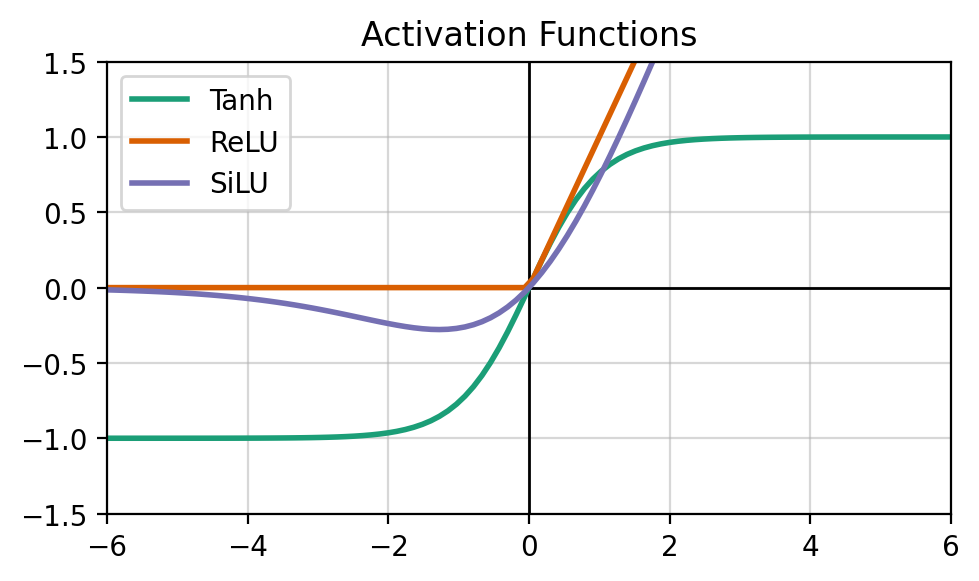

In [24]:
def get_activation(activation_f: str) -> nn.Module:
    activations = [
        nn.Tanh,
        nn.ReLU,
        nn.LeakyReLU,
        nn.SiLU,
        # ...
    ]
    names = [str(o.__name__).lower() for o in activations]
    try:
        return activations[names.index(str(activation_f).lower())]
    except:
        raise NotImplementedError(
            f'{activation_f=} is not yet implemented.')

# !plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot((-6, 6), (0, 0), 'k', lw=1)
ax.plot((0, 0), (-1.5, 1.5), 'k', lw=1)
x = torch.linspace(-6, 6, 100)
for i, activation_f in enumerate(['Tanh', 'ReLU', 'SiLU']):
    activation = get_activation(activation_f)()
    y = activation(x).detach().numpy()
    ax.plot(x, y, label=activation_f, lw=2, color=COLORS[i])

ax.legend()
ax.set_title('Activation Functions')
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(-6, 6)
ax.grid(True, alpha=0.5)
fig.tight_layout()

It is possible to define the gradient function to *backpropagate* errors and update our weights with a bit of calculus (e.g., using the chain rule). However, we can get around this step by using libraries such as [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/), or [MLX](https://github.com/ml-explore/mlx). Here we are using PyTorch. The main advantage is their support for *automatic differentiation*. Essentially, this allows us to only define the forward function and PyTorch will compute the gradient of our function for us!

So, let's define our first neural network! 

Below is the class for a multi-layer perceptron (`MLP`), which is synonymous with fully-connected network or dense neural network. This just defines a network of hidden layers, each with some number of nonlinear units, and a linear output layer (similar to {numref}`nnet01`).

In [25]:
class MLP(nn.Module):
    def __init__(self, 
                 n_inputs: int,
                 n_hiddens_list: Union[List, int],
                 n_outputs: int,
                 activation_f: str = 'tanh'
        ):
        super().__init__()

        if isinstance(n_hiddens_list, int):
            n_hiddens_list = [n_hiddens_list]

        if n_hiddens_list == [] or n_hiddens_list == [0]:
            self.n_hidden_layers = 0
        else:
            self.n_hidden_layers = len(n_hiddens_list)

        activation = get_activation(activation_f)

        self.layers = nn.ModuleList()
        ni = n_inputs
        if self.n_hidden_layers > 0:
            for n_units in n_hiddens_list:
                self.layers.append(nn.Linear(ni, n_units))
                self.layers.append(activation())
                ni = n_units
        self.layers.append(nn.Linear(ni, n_outputs))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape(x.shape[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

Great, let's make sure it works by passing some arbitrary input in to our network.

In [26]:
model = MLP(
    n_inputs=10,              # number of input features
    n_hiddens_list=[20, 10],  # two hidden layers with 20 and 15 units respectively
    n_outputs=5,              # number of output units
    activation_f='relu')      # activation function
print(model)

x = torch.randn(3, 10) # input tensor with shape (batch_size, n_inputs)
y = model(x)

print('Input shape:', x.shape)
print('Output shape:', y.shape)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=5, bias=True)
  )
)
Input shape: torch.Size([3, 10])
Output shape: torch.Size([3, 5])


`````{admonition} Question
*How do we **train** our neural network?*
`````

The `NeuralNetwork` class defined below handles training with the `train` function and inference with the `use` function. We can use this class for *most* neural network architectures, just by defining the `model` (e.g., `MLP`), `optimizer` (e.g., SGD or Adam), and `loss` function (e.g., mean-squared-error or cross entropy).

This class can be used for both *regression* and *classification* tasks (we will cover both in the coming sections) and perform operations on the CPU or GPU. The training loop is similar to that of linear and polynomial regression with gradient descent. However, PyTorch handels all the backward update rules for us. Once trained, we can make predictions with new samples.


In [27]:
class NeuralNetwork():
    def __init__(self, 
                 model: nn.Module, 
                 optimizer: torch.optim.Optimizer, 
                 loss: nn.Module,
                 use_gpu: bool = False
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss = loss

        # set device
        device = 'cpu'
        if use_gpu:
            if torch.cuda.is_available():
                device = 'cuda'
            elif torch.backends.mps.is_available():
                device = 'mps'
            else:
                print('\nNo GPU available. Running on CPU.\n')

        self.device = torch.device(device)
        self.model.to(self.device)

        print(f'Using device: {self.device}')

        # bookkeeping
        self.train_error_trace = []
        self.val_error_trace = []
    
    def train(self, train_data, val_data=None, epochs=10):
        total_start_t = time.time()
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            start_t = time.time()
            for X, T in train_data:
                X = X.to(self.device)
                T = T.to(self.device)

                # forward pass
                Y = self.model(X)
                loss = self.loss(Y, T)

                # backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item() / len(train_data)

            self.train_error_trace.append(train_loss)

            if val_data:
                self.model.eval()
                with torch.no_grad():
                    val_loss = 0
                    for X, T in val_data:
                        X = X.to(self.device, non_blocking=True)
                        T = T.to(self.device, non_blocking=True)
                        Y = self.model(X)
                        loss = self.loss(Y, T)
                        val_loss += loss.item() / len(val_data)
                    self.val_error_trace.append(val_loss)

            if epoch % max(1, epochs // 5) == 0:
                print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}', end='')
                print(f' - Val Loss: {val_loss:.4f}' if val_data else '', end='')
                print(f' - Time: {time.time() - start_t:.2f}s')

        print(f'Finished in {time.time() - total_start_t:.2f}s')

    def use(self, data):
        self.model.eval()
        with torch.no_grad():
            predictions = []
            for X, _ in data:
                X = X.to(self.device, non_blocking=True)
                Y = self.model(X)
                predictions.append(Y.cpu())
            return torch.cat(predictions, dim=0)

#### Regression

Let's begin with gathering our training and test data again. We need to transform this from a NumPy array to a torch `Dataset` and `DataLoader`. This is best practice when working with PyTorch. It is here that we define the batch size for stochastic updates and other data preparation like shuffling or transformations (not shown herein).

:::{seealso}
Additional references for DataLoaders:
- [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [Writing Custom Datasets, DataLoaders and Transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
- [Additional Class Documentation](https://pytorch.org/docs/stable/data.html)
:::

In [28]:
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8, shuffle=True, seed=42)
print(f'{Xtrain.shape=}, {Ttrain.shape=}, {Xtest.shape=}, {Ttest.shape=}')

batch_size = 64
train_dataset = TensorDataset(torch.tensor(Xtrain, dtype=torch.float32),
                              torch.tensor(Ttrain, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.tensor(Xtest, dtype=torch.float32),
                             torch.tensor(Ttest, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Xtrain.shape=(16512, 8), Ttrain.shape=(16512, 1), Xtest.shape=(4128, 8), Ttest.shape=(4128, 1)


Now we need only to (1) define our network architecture; (2) initialize our neural network for use; and (3) train the model with the training data. 

Given this is a regression problem, we are optimizing the [`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) and using the [`AdamW`](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html#adamw) optimizer. Try changing the hyperparameters yourself (i.e., number of hidden layers and units, activation function, learning rate, and number of epochs)!

In [30]:
torch.manual_seed(42)

n_inputs = Xtrain.shape[1]
n_hiddens_list = [16, 16]
n_outputs = Ttrain.shape[1]

model = MLP(n_inputs, n_hiddens_list, n_outputs, activation_f='relu')
print(model)

eta = 0.001
epochs = 20

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=eta)

nnet = NeuralNetwork(model, optimizer, loss_fn, use_gpu=False)
nnet.train(train_loader, test_loader, epochs=epochs)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
Using device: cpu
Epoch 1/20 - Train Loss: 2.2802 - Val Loss: 0.7401 - Time: 0.58s
Epoch 5/20 - Train Loss: 0.4297 - Val Loss: 0.4282 - Time: 1.08s
Epoch 9/20 - Train Loss: 0.3804 - Val Loss: 0.3886 - Time: 0.60s
Epoch 13/20 - Train Loss: 0.3482 - Val Loss: 0.3576 - Time: 0.56s
Epoch 17/20 - Train Loss: 0.3301 - Val Loss: 0.3403 - Time: 0.55s
Finished in 14.31s


The *learning curve* shows the loss of our model during training on both the training and validation data. Ideally, we want the two losses to be similar, or the validation loss below that of training. This signifies that our model has *generalized* well to data that it wasn't trained on.

This is what we see below!

A model that is *overfit* to the training data will not generalize well to data it has not seen before. This can be visualized when the validation loss exceeds that of the training loss. To see this happen, try changing the network architecture to `[100, 100, 100]`, and the model will be very overparameterized (i.e., the number of parameters is much greater than the number of training samples).

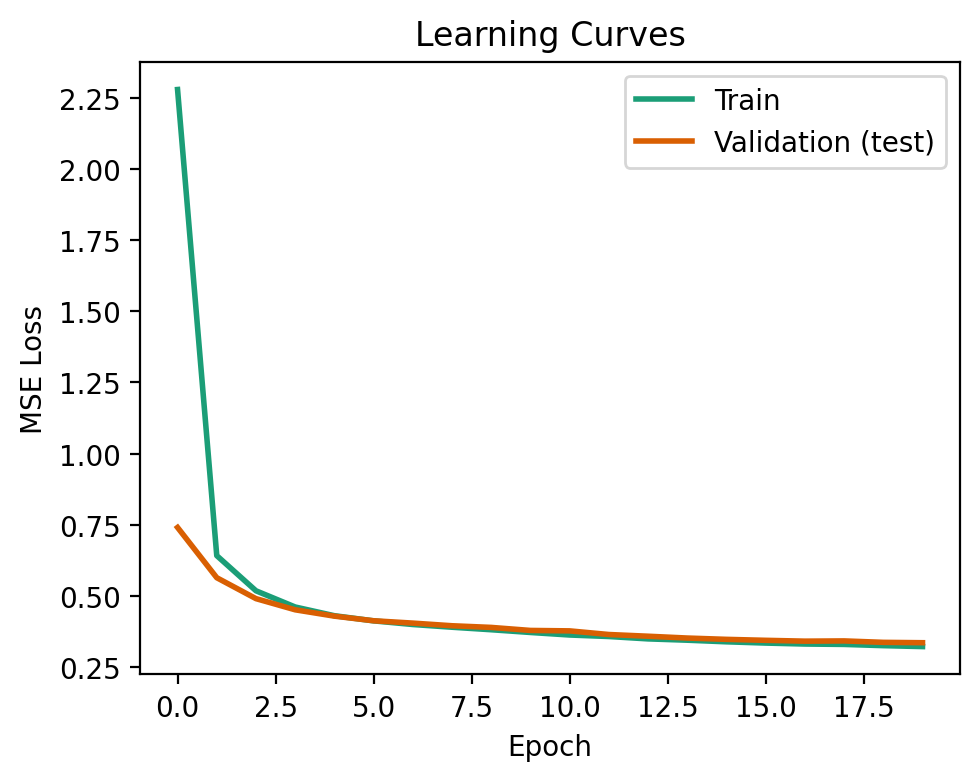

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(nnet.train_error_trace, label='Train', lw=2, color=COLORS[0])
ax.plot(nnet.val_error_trace, label='Validation (test)', lw=2, color=COLORS[1])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Learning Curves')
ax.legend()
fig.tight_layout()

As with before, let's evaluate our model! This is done by passing the *test data* to the `use` function of our network. The results are not significantly better than that of previous methods.

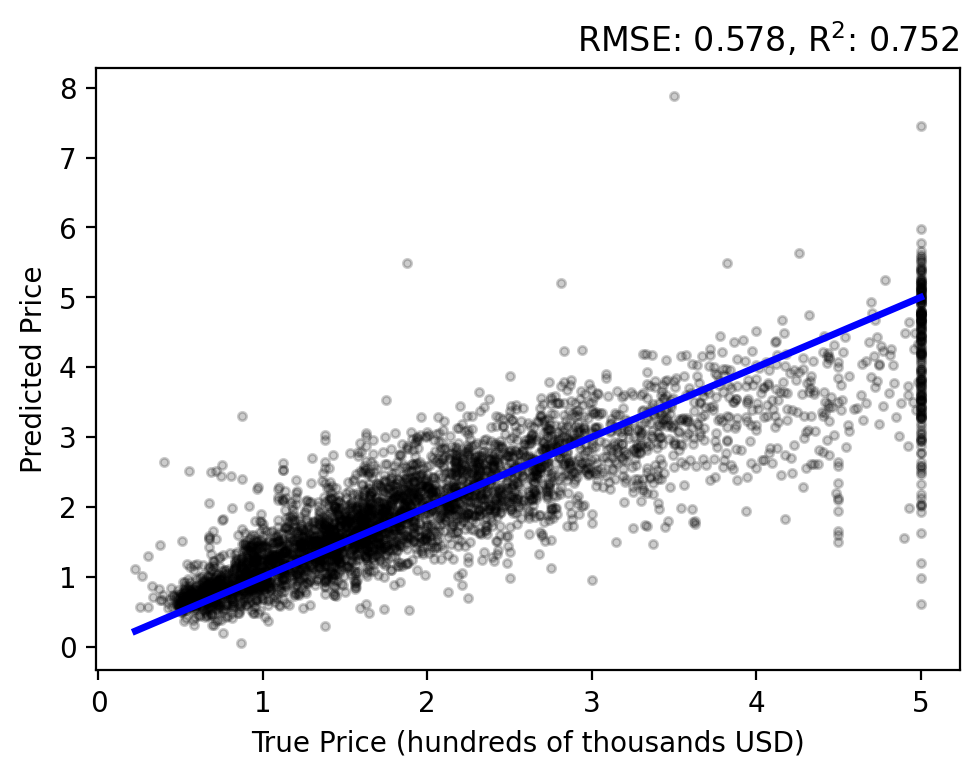

In [32]:
Ytest = nnet.use(test_loader).numpy()
plot_evaluation(Ttest, Ytest)

#### Classification

So far, we have only seen methods for regression, but what if we want to distinguish and categorize one sample from another? This is where classification comes in, and we aim to model $p(y = c \mid x)$, the probability that the class label $y$ equals a specific class $c$ given the input features $x$. We can do this with our existing neural network code!

Let's generate some **synthetic data**! This dataset has three distinct classes, each representing a different distribution of points in a 2D space. The data is constructed by generating $n$ samples for each class, resulting in a total of $3n$ samples. Our classes are:
- $c_0$: a downward parabola-like shape with some added noise.
- $c_1$: an upward parabola-like shape with added noise.
- $c_2$: a circular pattern of points with added noise.

The input features $\mathbf{X}$ consist of two dimensions, $x_0$ and $x_1$, which represent the coordinates of each point in the 2D space. The target labels $\mathbf{T}$ indicate the class to which each point belongs, with three possible classes.

X.shape=(1500, 2), T.shape=(1500,)


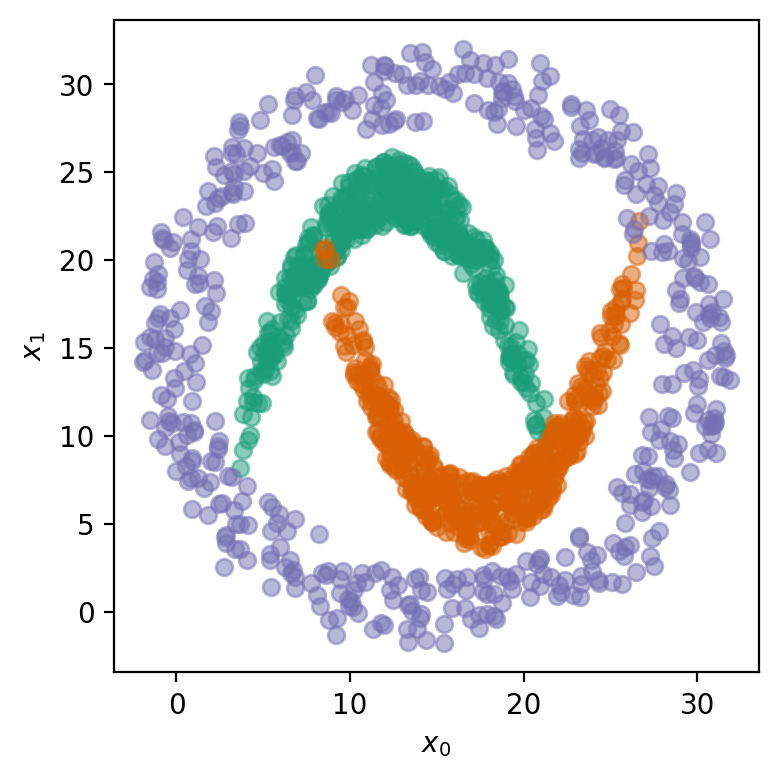

In [33]:
n = 500 # samples per class

x1 = np.linspace(5, 20, n) + np.random.uniform(-2, 2, n)
y1 = ((20-12.5)**2-(x1-12.5)**2) / (20-12.5)**2 * 10 + 14 + np.random.uniform(-2, 2, n)
x2 = np.linspace(10, 25, n) + np.random.uniform(-2, 2, n)
y2 = ((x2-17.5)**2) / (25-17.5)**2 * 10 + 5.5 + np.random.uniform(-2, 2, n)
angles = np.linspace(0, 2*np.pi, n)
x3 = np.cos(angles) * 15 + 15 + np.random.uniform(-2, 2, n)
y3 = np.sin(angles) * 15 + 15 + np.random.uniform(-2, 2, n)

X = np.vstack((np.hstack((x1, x2, x3)), 
               np.hstack((y1, y2, y3)))).T
T = np.repeat(range(3), n)
print(f'{X.shape=}, {T.shape=}')

# !plotting
fig = plt.figure(figsize=(4, 4))
for c in range(3):
    mask = (T == c).flatten()
    plt.plot(X[mask, 0], X[mask, 1], 'o', markersize=6, alpha=0.5, color=COLORS[c])
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
fig.tight_layout()

Now, similar to before, we create our `DataLoader` to manage and shuffle the data efficiently during training. We define the network architecture using our `MLP` class, where the number of outputs is set to the number of classes in our dataset. 

We're no longer optimizing the mean-squared error! Instea, we adjust the loss function to `nn.CrossEntropyLoss`, which is commonly used for classification tasks, and is defined as $\mathcal{L}_{\text{CE}} = -\sum_{i=1}^{C} t_i \log p_i$, where $t_i$ is the target label and $p_i$ is the Softmax probability for the $i^{th}$ class.

Using our network is the same as before!

In [36]:
torch.manual_seed(42)
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                        torch.tensor(T, dtype=torch.int64))
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

n_inputs = X.shape[1]
n_hiddens_list = [10, 10]
n_outputs = np.unique(T).shape[0] # the number of classes

model = MLP(n_inputs, n_hiddens_list, n_outputs, activation_f='relu')
print(model)

loss_fn = nn.CrossEntropyLoss() # we only need to change this!
optimizer = torch.optim.AdamW(model.parameters(), lr=0.003)

nnet = NeuralNetwork(model=model, optimizer=optimizer, loss=loss_fn, use_gpu=False)
nnet.train(train_loader, epochs=300)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)
Using device: cpu
Epoch 1/300 - Train Loss: 1.3402 - Time: 0.04s
Epoch 61/300 - Train Loss: 0.4252 - Time: 0.09s
Epoch 121/300 - Train Loss: 0.1632 - Time: 0.04s
Epoch 181/300 - Train Loss: 0.1420 - Time: 0.03s
Epoch 241/300 - Train Loss: 0.1152 - Time: 0.04s
Finished in 14.41s


To show the classes learned by the network, we generate test points and use the network to predict their class labels, visualizing the resulting decision regions. The predictions are made by converting the network’s output into discrete class labels by selecting the max output value with `torch.argmax`.

From the figures below, our network did well at distinguishing the descion regions!

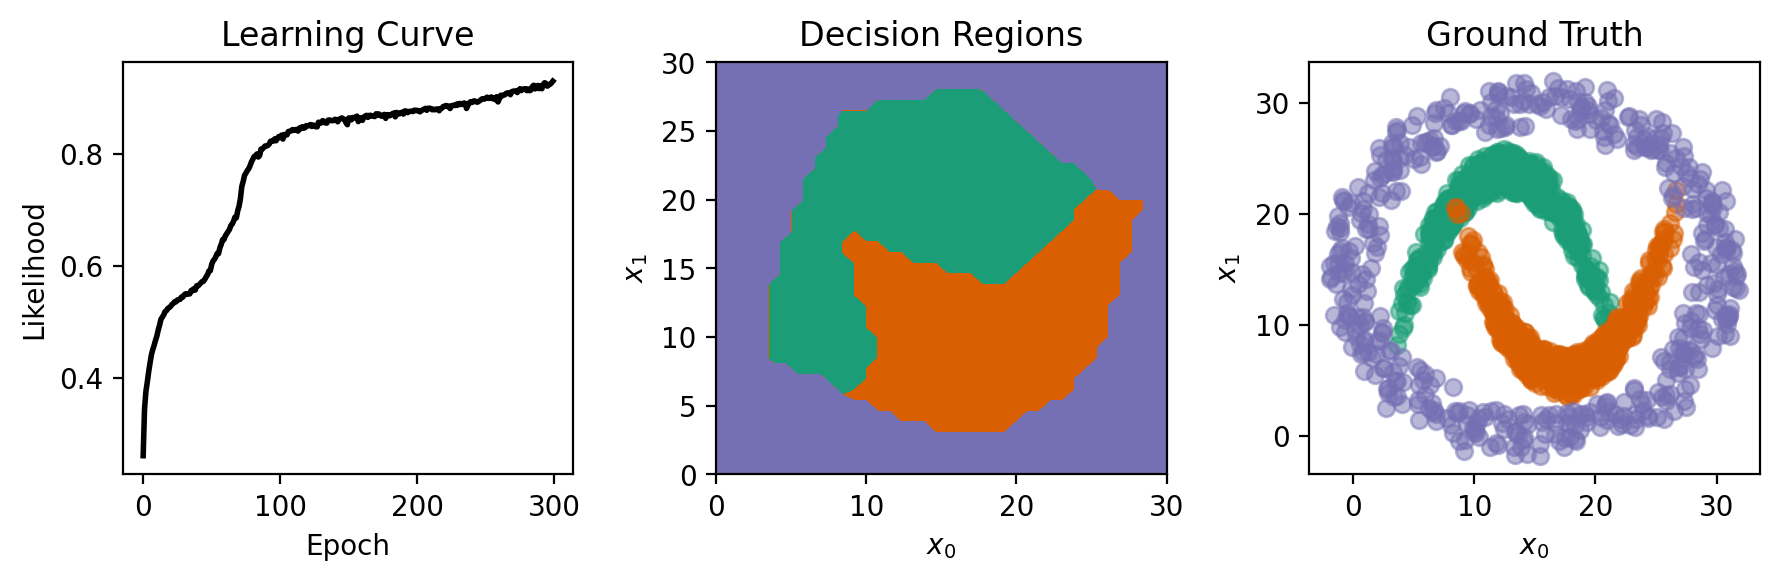

In [37]:
m = 40
xs = np.linspace(0, 30, m)
x, y = np.meshgrid(xs, xs)
Xtest = np.vstack((x.flat, y.flat)).T

test_dataset = TensorDataset(torch.tensor(Xtest, dtype=torch.float32), 
                             torch.zeros(Xtest.shape[0], dtype=torch.int64))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Ytest = torch.argmax(nnet.use(test_loader), dim=1) # convert predictions to class labels

# plotting
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].plot(np.exp(-np.array(nnet.train_error_trace)), 'k', lw=2)
axs[0].set_title('Learning Curve')
axs[0].set_ylabel('Likelihood')
axs[0].set_xlabel('Epoch')

axs[1].contourf(Xtest[:, 0].reshape((m, m)), Xtest[:, 1].reshape((m, m)),  Ytest.reshape((m, m))+1, 
             levels = [0.5, 1.99, 2.01, 3.5], colors=COLORS)
axs[1].set_title('Decision Regions')

for c in range(3):
    mask = (T == c).flatten()
    axs[2].plot(X[mask, 0], X[mask, 1], 'o', markersize=6, alpha=0.5, color=COLORS[c])
axs[2].set_title('Ground Truth')

for ax in axs[1:]:
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    
fig.tight_layout()

## Images

In the first part of this tutorial, we explored machine learning models for structured, tabular data. As we transition to image data, the focus shifts to visual information, where each image can be thought of as a grid of pixels with corresponding color or intensity values. This opens up possibilities for a wide range of applications, including recognizing objects, detecting patterns, and segmenting images in various domains.

An iconic datasets for image-based machine learning is [MNIST](https://yann.lecun.com/exdb/mnist/). This data consists of 60,000 training images and 10,000 testing images, each of which is a 28 $\times$ 28 grayscale image of handwritten digits, ranging from 0 to 9, with a label corresponding to the digit.

Let’s start by downloading and visualizing the data!

In [38]:
# download the MNIST data
# Suppress tqdm output while loading the MNIST dataset
with suppress_output():
    mnist_train = datasets.MNIST(root=DATA_DIR, train=True,  download=True)
    mnist_test = datasets.MNIST(root=DATA_DIR, train=False, download=True)

Xtrain = np.expand_dims(mnist_train.data.numpy() / 255., axis=1)
Ttrain = mnist_train.targets.numpy()
Xtest = np.expand_dims(mnist_test.data.numpy() / 255., axis=1)
Ttest = mnist_test.targets.numpy()

print(f'{Xtrain.shape=}, {Ttrain.shape=},\n{Xtest.shape=}, {Ttest.shape=}')
print('Training Label Count:')
for label, count in zip(*np.unique(Ttrain, return_counts=True)):
    print(f'\033[1m{label}\033[0m: {count}', end=', ')


Xtrain.shape=(60000, 1, 28, 28), Ttrain.shape=(60000,),
Xtest.shape=(10000, 1, 28, 28), Ttest.shape=(10000,)
Training Label Count:
0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949, 

We have a fairly equal number of examples per samples! Let's see how images from each of these classes look.

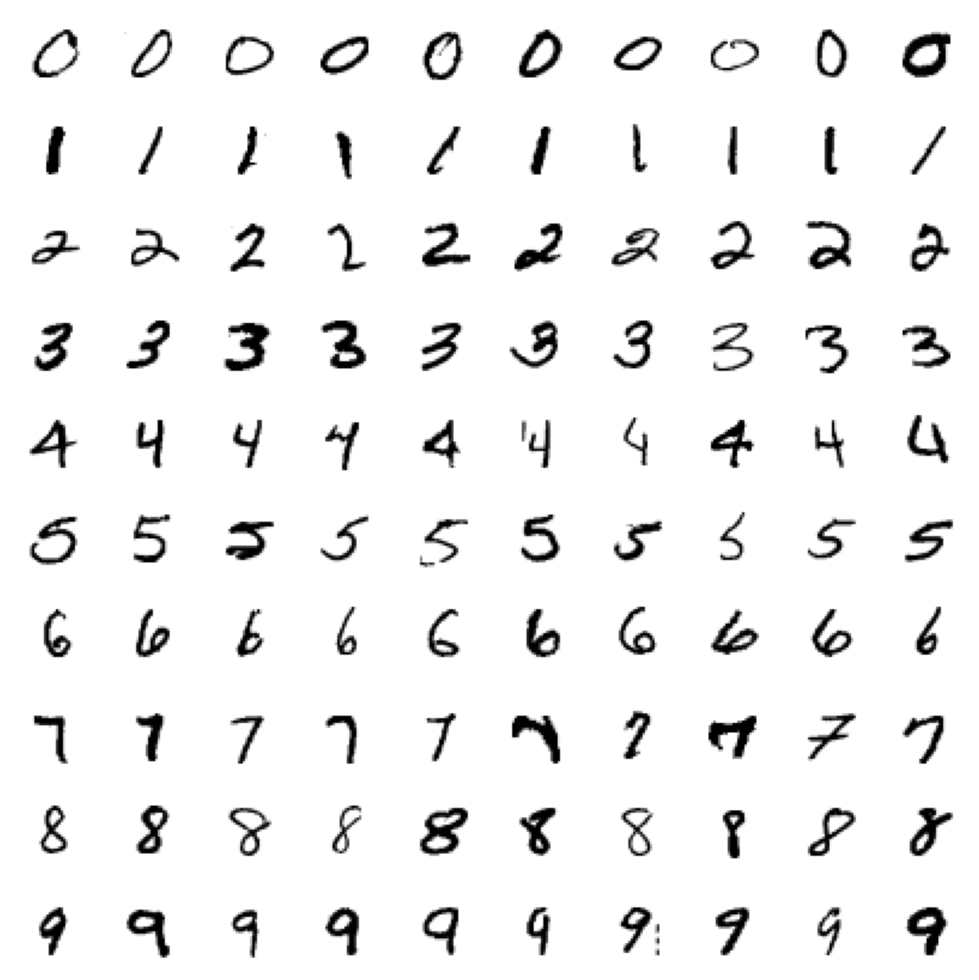

In [39]:
def plot_mnist_grid(X, T, seed=1234):
    np.random.seed(seed)
    fig, axs = plt.subplots(10, 10, figsize=(5, 5))
    for i, cls in enumerate(np.unique(T)):
        idx = np.where(T == cls)[0]
        idx = np.random.choice(idx, 10)
        for j in range(10):
            axs[i, j].imshow(X[idx[j], 0], cmap='gray_r')
            axs[i, j].axis('off')
    
    fig.tight_layout()

# change seed to see different samples
plot_mnist_grid(Xtrain, Ttrain, seed=1234)

Great! Now, we can start working with this data.

> **GOAL**: classify each image of a handwritten digit in the MNIST dataset into one of ten classes, corresponding to the numbers 0 through 9.

### Convolutional Neural Networks

We could convert our images into one-dimensional vector (or tabular) representations by flattening each image. This data could then be used with our fully-connected neural network or another tabular method as before. However, this approach has a significant drawback: it discards the spatial relationships inherent in the original image data. To preserve these spatial dependencies, we use convolutional layers, which are designed to recognize patterns and structures within the image, such as edges, textures, and shapes.

`````{admonition} Question
*What is a **convolution**?*
`````

A convolution is a mathematical operation where a filter (or kernel) *slides* over the image to extract specific features. Let’s explore this is by showing how a single predefined filter affects an image. 

Take the following digit...


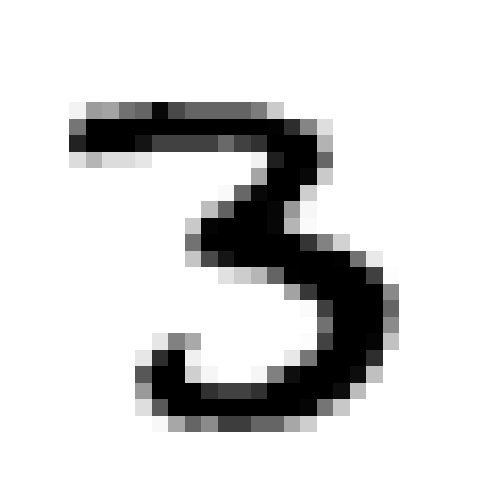

In [40]:
x = Xtrain[12, :].reshape(28, 28)
plt.figure(figsize=(3, 3))
plt.imshow(x, cmap='gray_r')
plt.axis('off');

For simplicty, we will break our image into 7 $\times$ 7 patches that shift by 2 columns and 2 rows, padding the original image to guarantee all patches are the same size.

The figure below shows these patches, were we some some overlap because we are using a stride that is less than that of the patch size.

num patches: 121, shape: (7, 7), rows/cols: 11.0


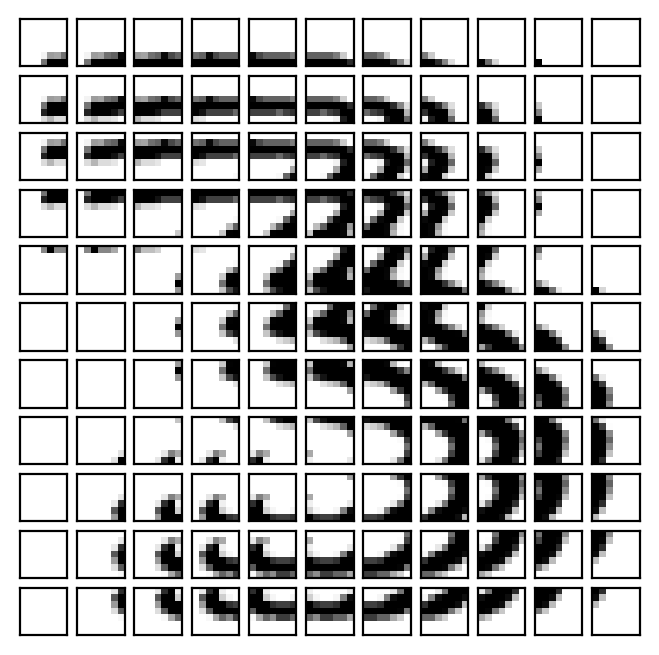

In [41]:
patch_size = 7
patches = []
for row in range(0, 28, 2):
    for col in range(0, 28, 2):
        if row + patch_size < 28 and col + patch_size < 28:
            patches.append(x[row:row + patch_size, col:col + patch_size])
patches = np.array(patches)
print(f'num patches: {len(patches)}, shape: {patches[0].shape}, rows/cols: {np.sqrt(len(patches))}')

# !plotting
n_plot_rows = int(np.sqrt(len(patches)))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches):
    plt.subplot(n_plot_rows, n_plot_rows, i + 1)
    plt.imshow(patch, cmap='gray_r')
    plt.xticks([]); plt.yticks([])

We’ll apply a Gaussian filter to smooth (or blur) the image. You can try different filters, such as edge detectors, to see how they affect the output.

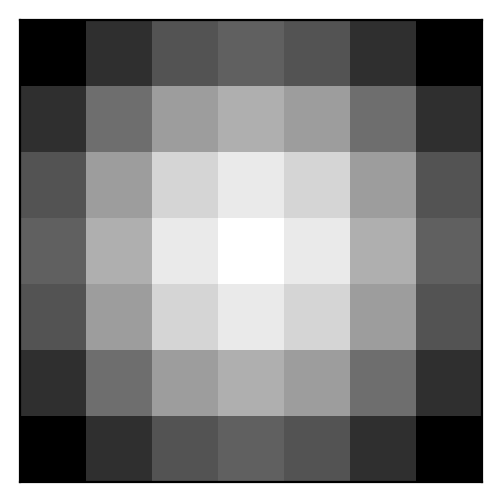

In [42]:
def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    """Generate a Gaussian kernel with standard deviation."""
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel) # normalize to sum to 1

weights = gaussian_kernel(patch_size, 3.0) # try increasing sigma!

## try using other weights, e.g. to detect
## diagonal edges from lower left to upper right
# weights = np.array([[-1, -1, -1, -1, -1, -1, -1],
#                     [-1, -1, -1, -1, -1, -1,  1],
#                     [-1, -1, -1, -1, -1,  1,  1],
#                     [-1, -1, -1, -1,  1,  1,  1],
#                     [-1, -1, -1,  1,  1,  1,  1],
#                     [-1, -1,  1,  1,  1,  1,  1],
#                     [-1,  1,  1,  1,  1,  1,  1]])

plt.figure(figsize=(3, 3))
plt.imshow(weights, cmap='gray')
plt.xticks([]); plt.yticks([]);

Let’s apply our filter and observe the resulting feature map!

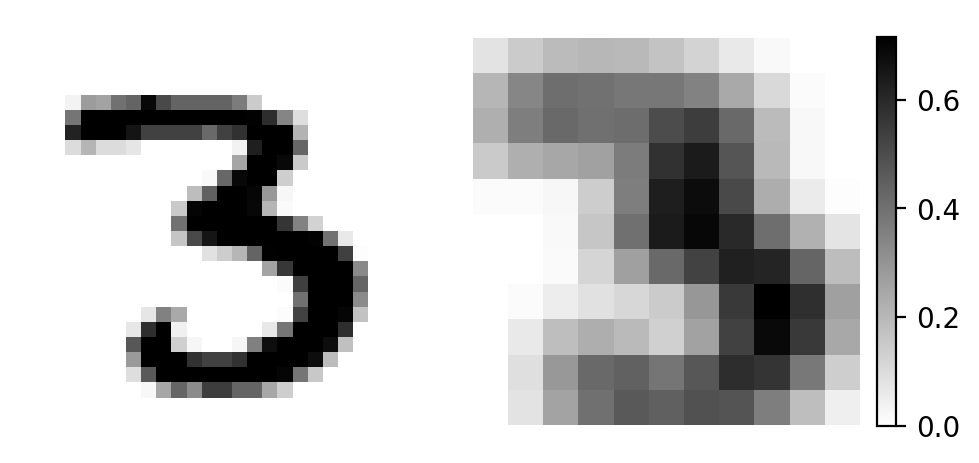

In [43]:
output = patches.reshape(len(patches), -1) @ weights.reshape(-1, 1) # matrix convolution

dim = int(np.sqrt(len(output)))
output = output.reshape(dim, dim)

# !plotting
fig, axs = plt.subplots(1, 2, figsize=(5, 3))
axs[0].imshow(x, cmap='gray_r')
im = axs[1].imshow(output, cmap='gray_r')
for ax in axs:
    ax.axis('off')
plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
plt.tight_layout()

Here we show 2D convolutions, but we could apply them across any dimension, commonly as 1D, 2D, or 3D.
:::{seealso}
Additional references on convolutions:
- [Image Kernels Explained Visually](https://setosa.io/ev/image-kernels/)
- [Mathematical Background on Convolutions](https://mathworld.wolfram.com/Convolution.html)
:::

`````{admonition} Question
*What if we are unsure about **what features to extract**?* 
`````

Instead of using predefined filters, we can actually *learn them using a neural network*! The [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer is used for just this. We can have mutliple filters in each layer that operate on each channel. With multiple layers of convolutions, the network’s early layers learn simple features like edges and textures, while later layers capture more complex patterns, such as shapes or objects. This hierarchical structure allows the network to progressively build a detailed and abstract representation of the image.

{numref}`cnn-im` depicts a convolutional neural network for a classification task with an image as input and taget class as output. Starting with convolutional layers (and pooling to downsample the image), we learn our abstract spatial representation and pass it to fully-connected layers to classify the \[object in the\] image. While this illustrates a classification task, convolutional neural networks can be used for other tasks, such as regression, among others.

:::{figure-md} cnn-im
<img src="../../img/machine-learning/cnn.png" alt="cnn-im" width="600px">

Convolutional neural network architecture ([MathWorks](https://www.mathworks.com/discovery/convolutional-neural-network.html)).
:::

In PyTorch, we define the `CNN` class as follows:

In [44]:
class CNN(nn.Module):
    def __init__(self, 
                 n_inputs: int,
                 conv_layers: List[dict],
                 n_hiddens_list: Union[List, int],
                 n_outputs: int,
                 activation_f: str = 'relu'
        ):
        super().__init__()

        if isinstance(n_hiddens_list, int):
            n_hiddens_list = [n_hiddens_list]

        if n_hiddens_list == [] or n_hiddens_list == [0]:
            self.n_hidden_layers = 0
        else:
            self.n_hidden_layers = len(n_hiddens_list)

        activation = get_activation(activation_f)

        self.layers = nn.ModuleList()
        ni = np.asarray(n_inputs)

        # add conv layers
        if conv_layers:
            for conv_layer in conv_layers:
                n_channels = ni[0]  # C, H, W
                self.layers.append(nn.Conv2d(n_channels, conv_layer['n_filters'], conv_layer['shape'], 
                                            stride=1, padding='same', padding_mode='zeros'))
                self.layers.append(activation())
                self.layers.append(nn.MaxPool2d(2, stride=2))
                ni = np.concatenate([[conv_layer['n_filters']], ni[1:] // 2])

        if ni.ndim > 0:
            self.layers.append(nn.Flatten())
        ni = np.prod(ni)

        # add fully connected layers
        if self.n_hidden_layers > 0:
            for n_units in n_hiddens_list:
                self.layers.append(nn.Linear(ni, n_units))
                self.layers.append(activation())
                ni = n_units
        self.layers.append(nn.Linear(ni, n_outputs))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

Now, we can adjust the number of convolutions with the `conv_layers` parameter. For each element is a `dict` with the number of filters and its shape. Let's make sure everything works okay...

In [45]:
conv_layers = [
    {'n_filters': 4, 'shape': 3},
    {'n_filters': 8, 'shape': 3}
]

x = torch.randn(8, 3, 32, 32)
model = CNN(n_inputs=x.shape[1:], 
            n_hiddens_list=[32, 16], 
            n_outputs=10, 
            conv_layers=conv_layers, 
            activation_f='relu')
Y = model(x)
print(Y.shape)

torch.Size([8, 10])


Great! We can now instantiate our model and pass it into the `NeuralNetwork` class for training and inference. 

In [47]:
torch.manual_seed(42)

batch_size = 128  # reduce if you run out of memory
train_dataset = TensorDataset(torch.tensor(Xtrain, dtype=torch.float32),
                              torch.tensor(Ttrain, dtype=torch.int64))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(torch.tensor(Xtest, dtype=torch.float32),
                             torch.tensor(Ttest, dtype=torch.int64))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

conv_layers = [
    {'n_filters': 4, 'shape': 3},
    {'n_filters': 8, 'shape': 3}
]
model = CNN(n_inputs=Xtrain.shape[1:],            # input shape, e.g. (C, H, W)
            conv_layers=conv_layers,              # convolutional layers
            n_hiddens_list=[16],                  # fully-connected layers
            n_outputs=np.unique(Ttrain).shape[0], # number of classes
            activation_f='relu')
print(model)

eta = 0.001
epochs = 5

loss_fn = nn.CrossEntropyLoss() # this is for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

nnet = NeuralNetwork(model, optimizer, loss_fn, use_gpu=True)
nnet.train(train_loader, test_loader, epochs=epochs)

CNN(
  (layers): ModuleList(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=392, out_features=16, bias=True)
    (8): ReLU()
    (9): Linear(in_features=16, out_features=10, bias=True)
  )
)
Using device: mps
Epoch 1/5 - Train Loss: 0.7431 - Val Loss: 0.3359 - Time: 24.38s
Epoch 2/5 - Train Loss: 0.2805 - Val Loss: 0.2257 - Time: 20.50s
Epoch 3/5 - Train Loss: 0.2071 - Val Loss: 0.1738 - Time: 19.68s
Epoch 4/5 - Train Loss: 0.1668 - Val Loss: 0.1373 - Time: 18.84s
Epoch 5/5 - Train Loss: 0.1386 - Val Loss: 0.1173 - Time: 18.48s
Finished in 101.88s


`````{admonition} Question
*Our model has finished training, so **what has it learned**?* 
`````

Well, as with our initial convolution example, we can visualize the filters, although now they are more abstract. Try changing the `layer_inx` to see (a subset of) the filters in each layer.

weights.shape=(4, 1, 3, 3)


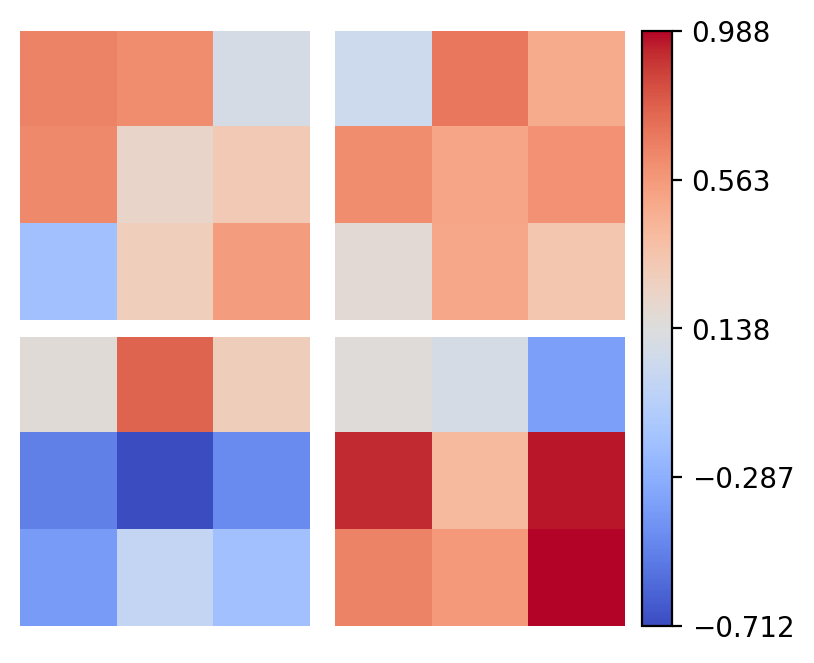

In [48]:
layer_idx = 0  # try changing to 3 to see the second conv layer (some filters not plotted)
weights = model.layers[layer_idx].weight.data.cpu().numpy()
print(f'{weights.shape=}')

# !plotting
row_col = int(np.sqrt(weights.shape[0]))
vmin, vmax = weights.min(), weights.max()
fig, axs = plt.subplots(row_col, row_col, figsize=(4, 3.2), constrained_layout=True)
axs = axs.ravel()
cmap = plt.get_cmap('coolwarm')
for i in range(row_col**2):
    axs[i].imshow(weights[i,0], vmin=vmin, vmax=vmax, cmap=cmap)
    axs[i].axis('off')
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axs, ticks=np.linspace(vmin, vmax, 5), 
                    orientation='vertical', pad=0.03)

Because this is a classification task, we are interested in how well we accurately predict each class. This is done by computing the *accuracy* between the predicted and target classes on the *test data* (i.e., examples not seen before).

Additionally, we can see how well each class performed with a *confusion matrix*. This shows for each row, a count of the target class and what the model predicted it to be. The diagonal shows the number correctly predicted samples. For example, we can see the digit `1` is often misclassified as a `7` and a `4` is misclassified as a `9`, but not vice-versa.

In [49]:
Ytest = torch.argmax(nnet.use(test_loader), dim=1).numpy()

print(f'Test Accuracy: {np.mean(Ttest == Ytest)*100:.2f}%')

print('\nConfusion Matrix:\n')
num_classes = len(np.unique(Ttest))
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(Ttest, Ytest):
    conf_matrix[true_label, pred_label] += 1
max_width = max(len(str(np.max(conf_matrix))), len('True'))
print(' ' * (max_width + 8) + 'Predicted')
print(' ' * (max_width + 9) + ' '.join([f'{i:>{max_width}}' for i in range(num_classes)]))
print(' ' * (max_width + 8) + '-' * (num_classes * (max_width + 1)))
for i, row in enumerate(conf_matrix):
    l = 'True' if i == 0 else '    '
    print(f'{l:>{max_width + 4}}{i:2} | ' + ' '.join([f'{x:>{max_width}}' for x in row]))

Test Accuracy: 96.50%

Confusion Matrix:

            Predicted
                0    1    2    3    4    5    6    7    8    9
            --------------------------------------------------
    True 0 |  966    0    1    1    0    3    3    2    4    0
         1 |    0 1112    4    3    0    0    5    0   11    0
         2 |    5    2 1000    7    2    0    2    6    7    1
         3 |    0    0    3  978    0   15    0    7    7    0
         4 |    0    0    4    1  948    0    8    2    3   16
         5 |    2    0    0   11    0  868    6    0    4    1
         6 |    1    2    4    1    5    7  934    0    4    0
         7 |    0    3   17    6    0    0    0  988    0   14
         8 |    3    0    5   14    8    9    9    6  914    6
         9 |    5    6    0   10   17    7    1   11   10  942


`````{admonition} Question
*What do some of the **misclassified samples** look like?* 
`````

The figure below shows some examples, and they seem to make *some* sense... comparing the target $t_i$ with the predicted values $y_i$, it can be difficult to recognize what the digit truly is at a glance.

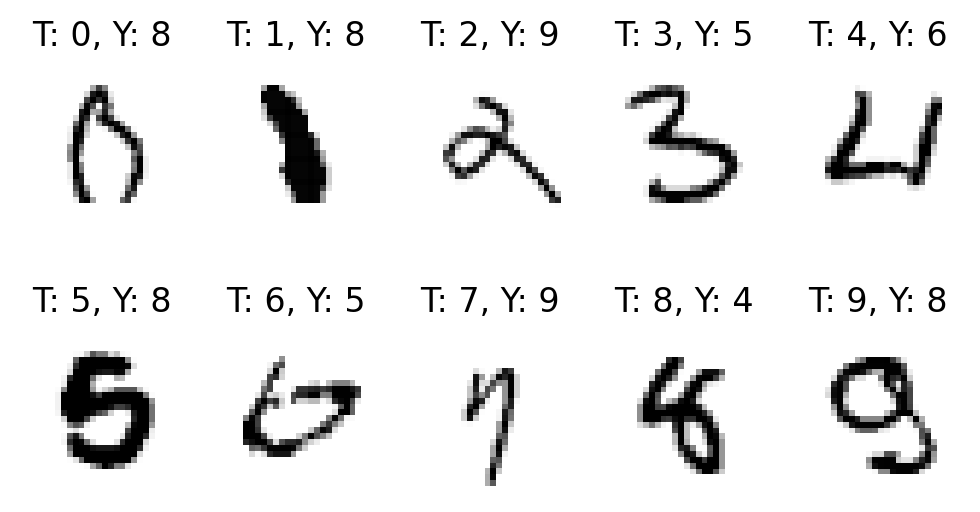

In [50]:
fig, axes = plt.subplots(2, 5, figsize=(5, 3))
for i, ax in enumerate(axes.flatten()):
    mask = (Ttest == i) & (Ytest != i)
    idx = np.where(mask)[0][0]
    ax.imshow(Xtest[idx, 0], cmap='gray_r')
    ax.set_title(f'T: {Ttest[idx]}, Y: {Ytest[idx]}')
    ax.axis('off')
fig.tight_layout()

### Image-to-Image Translation

Instead of estimating a class or scalar output, we may want learn the *transformation between two images*. For example, we might want to map low-resolution satellite imagery to high-resolution outputs or transform a medical scan to segment out tumors or organs. The UNet architecture, introduced in [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in 2015, is designed for this task.

{numref}`unet` illustrates the architecture, which is comprised of an **encoder** to downsamples the image and extract features, a **decoder** to upsample the image and reconstruct the output, and **skip connections** to transfer fine-grained details from the encoder to the decoder.

:::{figure-md} unet
<img src="../../img/machine-learning/unet.png" alt="unet" width="600px">

Convolutional UNet architecture ([Ronneberger et al. (2015)](https://arxiv.org/abs/1505.04597)).
:::

Converting this to PyTorch, we have the following `UNet` class!

In [51]:
class UNet(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 out_channels: int,
                 depth: int,
                 initial_filters: int = 32,
                 activation_f: str = 'relu'
        ):
        super().__init__()
        
        self.depth = depth
        activation = get_activation(activation_f)
        
        # downsampling
        self.down_layers = nn.ModuleList()
        self.pooling_layers = nn.ModuleList()
        filters = initial_filters
        for _ in range(depth):
            self.down_layers.append(nn.Sequential(
                nn.Conv2d(in_channels, filters, kernel_size=3, padding=1),
                nn.BatchNorm2d(filters),
                activation(),
                nn.Conv2d(filters, filters, kernel_size=3, padding=1),
                nn.BatchNorm2d(filters),
                activation()
            ))
            self.pooling_layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = filters
            filters *= 2
        
        # latent
        self.latent_layer = nn.Sequential(
            nn.Conv2d(filters // 2, filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters),
            activation(),
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(filters),
            activation()
        )
        
        # upsampling
        self.up_layers = nn.ModuleList()
        self.upsample_layers = nn.ModuleList()
        filters = filters // 2
        for _ in range(depth):
            self.upsample_layers.append(nn.ConvTranspose2d(filters * 2, filters, kernel_size=2, stride=2))
            self.up_layers.append(nn.Sequential(
                nn.Conv2d(filters * 2, filters, kernel_size=3, padding=1),
                nn.BatchNorm2d(filters),
                activation(),
                nn.Conv2d(filters, filters, kernel_size=3, padding=1),
                nn.BatchNorm2d(filters),
                activation()
            ))
            filters //= 2
        
        # output
        self.output = nn.Conv2d(filters * 2, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encodings = []
        for i, layer in enumerate(self.down_layers):
            x = layer(x)
            encodings.append(x)
            x = self.pooling_layers[i](x)
        
        x = self.latent_layer(x)
        
        for i, layer in enumerate(self.up_layers):
            x = self.upsample_layers[i](x)
            x = torch.cat([x, encodings[-(i+1)]], dim=1)
            x = layer(x)
        
        x = self.output(x)
        return x

We assume the input ($\text{C}_\text{in} \times H \times W$) has the same resolution as the output ($\text{C}_\text{out} \times H \times W$), but the number of channels may differ. This may be the case when using multiple data sources. For example, in translating satellite imagery to radar reflectivity, where there may be multiple infrared channels as input to a singular output channel of composite reflectivity (see the reference below).

:::{seealso}
Example UNet with different intput/output domains and channels: [Development and Interpretation of a Neural-Network-Based Synthetic Radar Reflectivity Estimator Using GOES-R Satellite Observations](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml) by Hilburn et al. (2021).
:::

In [52]:
x = torch.randn(1, 3, 64, 64) # input (batch_size, channels, height, width)

model = UNet(in_channels=x.shape[1], # for example, 3 channels for RGB images
             out_channels=1,         # for example, 1 channel for binary segmentation
             depth=2,                # depth of the UNet, number of down/up sampling layers
             initial_filters=16,     # number of filters in the first layer
             activation_f='relu')    # activation function
# print(model)

y = model(x)

print('Input shape:', x.shape)
print('Output shape:', y.shape)

Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 1, 64, 64])


We need some data now...

Rather than introducing an entirely new dataset, let's just use the MNIST data we imported previously. Although, we will no longer be using it for classification. Instead, we are going to modify the data by slicing each digit in half, showing only part of the image as input.

> **GOAL**: reconstruct the original digit from only its part, or slice of the original image.

This will become more clear once visualized.

In [56]:
def create_half_images(X):
    X[:, :, :, X.shape[-1] // 2:] = 0  # mask half of the image (right side)
    return X

def select_n_per_class(X, T, n, seed=1234):
    np.random.seed(seed)

    selected_indices = np.hstack([
        np.random.choice(np.where(T == cls)[0], n, replace=False)
        for cls in np.unique(T)
    ])
    
    np.random.shuffle(selected_indices)
    return X[selected_indices], T[selected_indices]

# start with a new copy of the data
Xtrain = np.expand_dims(mnist_train.data.numpy() / 255., axis=1)
Ttrain = mnist_train.targets.numpy()
Xtest = np.expand_dims(mnist_test.data.numpy() / 255., axis=1)
Ttest = mnist_test.targets.numpy()

# prepare dataset
n_per_class = 50 # samples per class, reduce if you run out of memory

Xtrain, Ctrain = select_n_per_class(Xtrain, Ttrain, n_per_class)
Ttrain = Xtrain.copy()
Xtrain = create_half_images(Xtrain)

Xtest, Ctest = select_n_per_class(Xtest, Ttest, n_per_class)
Ttest = Xtest.copy()
Xtest = create_half_images(Xtest)

print(f'{Xtrain.shape=}, {Ttrain.shape=}, {Xtest.shape=}, {Ttest.shape=}')

Xtrain.shape=(500, 1, 28, 28), Ttrain.shape=(500, 1, 28, 28), Xtest.shape=(500, 1, 28, 28), Ttest.shape=(500, 1, 28, 28)


The `select_n_per_class` will select a subset of samples that are equally distributed from each class. This is just to reduce the total number of samples and computational overhead. Increasing the number of samples per class (`n_per_class`) may result in better performance at the cost of training speed.

Now to visualize the data...

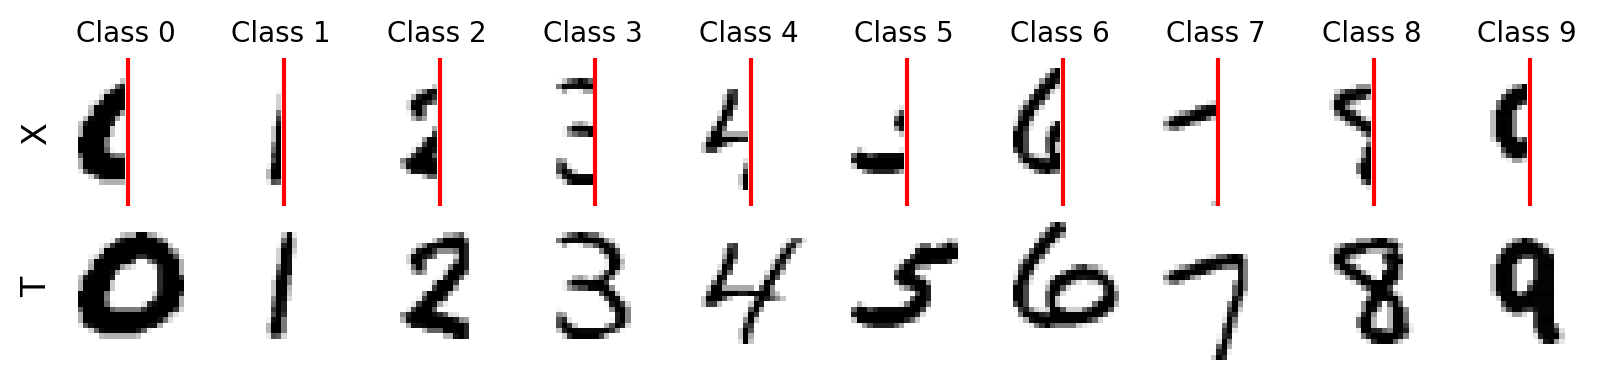

In [54]:
# !plotting
def show_images(X, C, T=None, Y=None, difference=False, seed=1234):
    np.random.seed(seed)
    indices = [np.random.choice(np.where(C == c)[0]) for c in np.unique(Ctrain)]
    
    X_examples = X[indices]
    C_examples = C[indices]
    T_examples = T[indices] if T is not None else None
    Y_examples = Y[indices] if Y is not None else None
    
    n = len(X_examples)
    rows = sum(1 for arr in [X_examples, T_examples, Y_examples] if arr is not None) + \
           (1 if difference and T_examples is not None and Y_examples is not None else 0)
    
    plt.figure(figsize=(n, 2.5 * rows))
    
    def plot_images(images, row_idx, label, cmap='gray_r'):
        vmax = max(abs(images.min()), abs(images.max())) if cmap == 'coolwarm' else 1
        vmin = -vmax if cmap == 'coolwarm' else 0
        
        for i in range(n):
            ax = plt.subplot(rows, n, row_idx * n + i + 1)
            im = plt.imshow(images[i, 0], vmin=vmin, vmax=vmax, cmap=cmap)
            if label == 'X':
                ax.axvline(images.shape[2] // 2, color='r', lw=1.5)
            ax.axis('off')
            if row_idx == 0:
                ax.set_title(f'Class {C_examples[i]}', fontsize=10)
            if i == 0:
                ax.annotate(label, xy=(-0.1, 0.5), xycoords='axes fraction', fontsize=12,
                            ha='center', va='center', rotation=90)
        
        if cmap == 'coolwarm' and row_idx == rows - 1:
            cbar_ax = plt.gcf().add_axes([0.905, 0.341, 0.1 / n, 0.075])
            plt.colorbar(im, cax=cbar_ax)
    
    plot_images(X_examples, 0, 'X')
    if T_examples is not None:
        plot_images(T_examples, 1, 'T')
    if Y_examples is not None:
        plot_images(Y_examples, 2, 'Y')
    if difference and T_examples is not None and Y_examples is not None:
        plot_images(T_examples - Y_examples, 3, 'T $-$ Y', cmap='coolwarm')
    
    hspace_map = {2: -0.75, 3: -0.817, 4: -0.855}
    plt.subplots_adjust(wspace=0.05, hspace=hspace_map.get(rows, 0))
    plt.show()

show_images(Xtrain, Ctrain, Ttrain, seed=42) # change seed to see different samples

Great! We can see each input sample $\mathbf{x}_i$ and its target $\mathbf{t}_i$. The <span style="color: red;">red line</span> is just for visualization purposes. There is also only one channel for both the input and output. 

By learning to reconstruct a digit, we hope to generalize to new samples and estimate the fully written out digit by showing only half the digit as input. We can use our `NeuralNetwork` class to train our model again.

```{note}
*This model is larger (has more parameters and operations) than those previously. It may take some time to run. Reducing `n_per_class` may speed things up at the cost of performance.*
```

In [62]:
torch.manual_seed(42)

batch_size = 128 # reduce if you run out of memory
train_dataset = TensorDataset(torch.tensor(Xtrain, dtype=torch.float32), 
                              torch.tensor(Ttrain, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(torch.tensor(Xtest, dtype=torch.float32), 
                             torch.tensor(Ttest, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = UNet(in_channels=1, out_channels=1, depth=2, initial_filters=8, activation_f='relu')

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

nnet = NeuralNetwork(model, optimizer, loss_fn, use_gpu=True)
nnet.train(train_loader, test_loader, epochs=20)

Using device: mps
Epoch 1/20 - Train Loss: 0.1343 - Val Loss: 0.1241 - Time: 0.53s
Epoch 5/20 - Train Loss: 0.0470 - Val Loss: 0.0960 - Time: 0.78s
Epoch 9/20 - Train Loss: 0.0369 - Val Loss: 0.0592 - Time: 0.58s
Epoch 13/20 - Train Loss: 0.0316 - Val Loss: 0.0392 - Time: 0.60s
Epoch 17/20 - Train Loss: 0.0279 - Val Loss: 0.0304 - Time: 0.61s
Finished in 12.94s


The learning curves below show our model is starting to overfit (training loss diverging negatively from the validation loss) with `n_per_class=50`. The performance on new, test samples may not be as good as a result. 

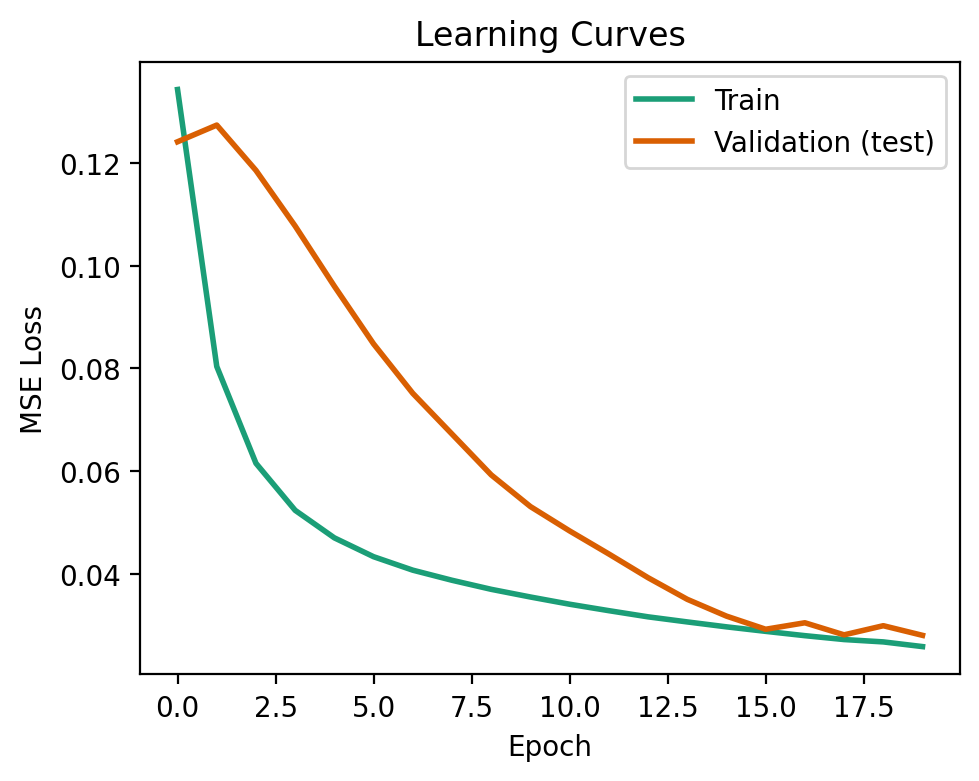

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(nnet.train_error_trace, label='Train', lw=2, color=COLORS[0])
ax.plot(nnet.val_error_trace, label='Validation (test)', lw=2, color=COLORS[1])
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Learning Curves')
ax.legend()
fig.tight_layout()

Let's see how we did... WOW!

Visualizing the results show the predicted digit (from the test data) below the targets, and the digits are  reconstructed qualitatively well, but there are some artifacts. The last row of the figure below has the difference $\mathbf{t_i} - \mathbf{y_i}$, where we can see for which part of the digit has the greatest errors. Try changing the seed to see different examples.

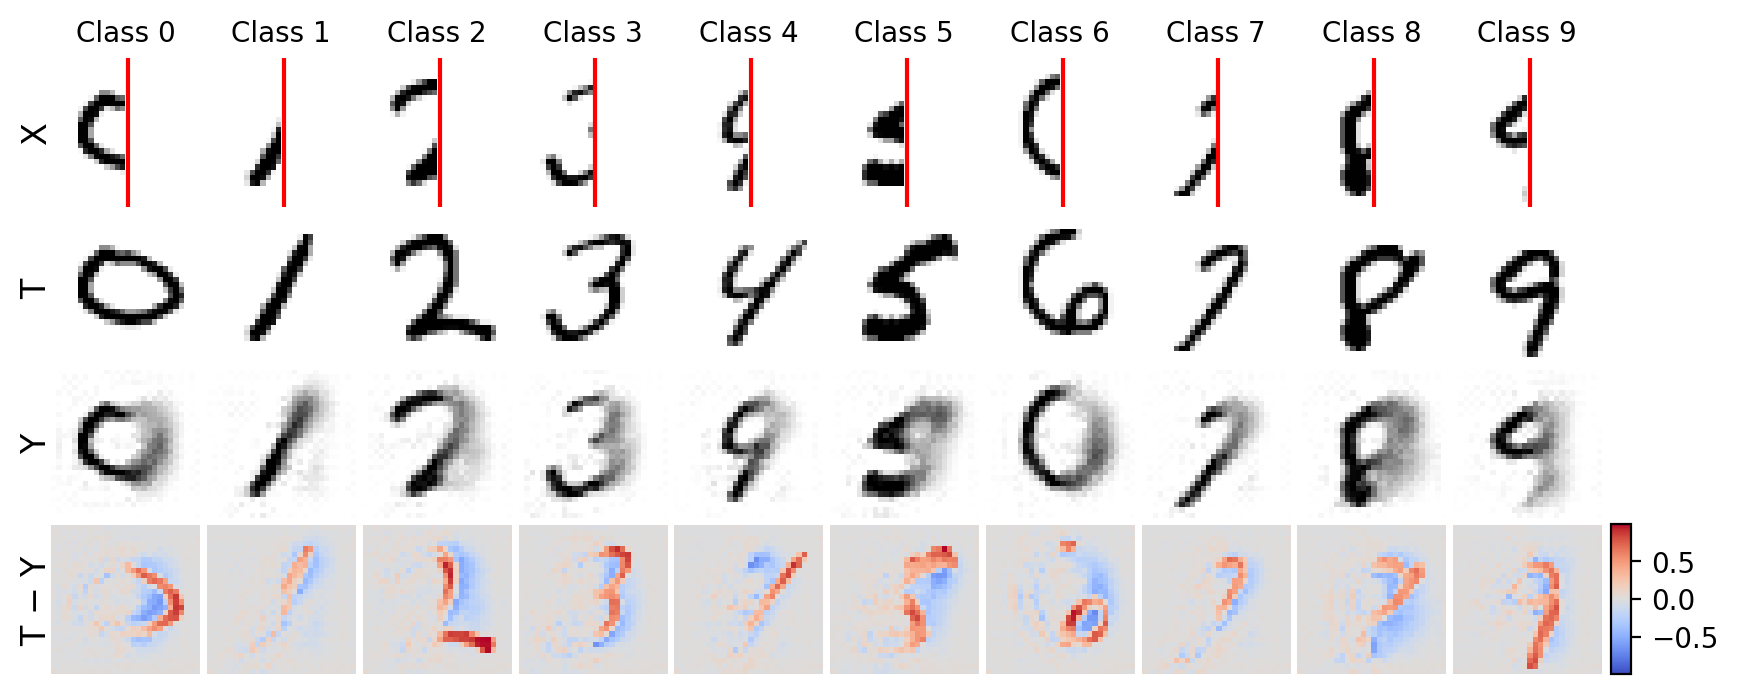

In [64]:
Ytest = nnet.use(test_loader).numpy()
show_images(Xtest, Ctest, Ttest, Ytest, difference=True, seed=5) # change seed to see different examples

**Drawbacks**: the *blurriness* we see in the output is actually an artifact of optimizing the *mean-squared-error*, which essentially learns the "ensemble" mean of the data. Generative modeling, an active field of research, has been shown to generate much sharper and more accurate outputs for image-to-image translation. In fact, the `UNet` architecture is *sometimes* used in these methods. However, generative models are out of scope for this tutorial, but more information can be found below.

:::{seealso}
A brief collection of generative modeling resources:
- [A Brief Introduction to Generative Models](https://arxiv.org/abs/2103.00265)
- [Step-by-Step Diffusion: An Elementary Tutorial](https://arxiv.org/abs/2406.08929)
:::

## Time Series

The world presents itself sequentially. As you read this, you are building up an understanding of each word based on what you saw previously. Many datasets have this temporal relationship where the order of data points matters. For example, in weather forecasting, the temperature at a given time is influenced by the temperatures recorded earlier in the day. And what if we want to forecast the temperature out into the future? Traditional neural networks, as we saw previously, are not well suited for sequential data because they treat each input independently, ignoring the temporal dependencies between data points. 

Let's discuss and see some methods for modeling time series data!

### Recurrent Neural Networks

Unlike traditional fully-connected networks, which treat each input independently, recurrent networks have connections that loop back on themselves, allowing them to maintain a "memory" of previous inputs. The key idea is to processes data one step at a time, updating its internal state based on both the current input and the state from the previous step. {numref}`rnn-unrolled` illustrates this, where we have a *variable length* <span style="color: blue;">input sequence</span> $x_0, x_1, \dots, x_t$, <span style="color: green;">recurrent cell</span> $A$, and <span style="color: purple;">output</span> $h_0, h_1, \dots, h_t$. Essentially, we can think of this as having multiple copies of the same network, with each passing a message to its successor.

:::{figure-md} rnn-unrolled
<img src="../../img/machine-learning/rnn-unrolled.png" alt="rnn-unrolled" width="500px">

An unrolled recurrent neural network ([Olah 2015](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)).
:::

The computation in each <span style="color: green;">recurrent cell</span> in a standard recurrent network combines the current <span style="color: blue;">input</span> with the <span style="color: purple;">hidden state</span> of the previous step. This is illustrated in {numref}`rnn-cell`. We can perform this for as many sequential steps as we would like. A common variant to the <span style="color: green;">recurrent cell</span> is [Long-Short-Term Memory](https://www.bioinf.jku.at/publications/older/2604.pdf) (LSTM) from Hochreiter & Schmidhuber (1997). There are just some additional computations that happen when combining a given input with previous state, but the overall concepts are similar. 

:::{figure-md} rnn-cell
<img src="../../img/machine-learning/rnn-cell.png" alt="rnn-cell" width="500px">

A single layer standard RNN cell ([Olah 2015](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)).
:::

There are many different tasks we can do with recurrent networks, depending on the input data we have and how we use the input for each step. This can be summarized as:
- **one-to-many**: one input, multiple outputs (e.g., image captioning)
- **many-to-many**: multiple inputs, multiple outputs (e.g., language translation, speech-to-text)
- **many-to-one**: multiple inputs, single output (e.g., sentiment analysis, temperature forecasting)

Let's explore a many-to-one task to model a sine wave. Specifically, we will use as input $\mathbf{x}$ a sine wave sampled on a period of $\pi$ with varying phase shifts between $[0, 2\pi]$, and a target $t$ from the final step in the sequence.

> **GOAL**: generate a rollout of a sine wave given only part of the sequence.

Starting by generating and visualizing the data...

X.shape=(200, 30, 1), T.shape=(200, 1)


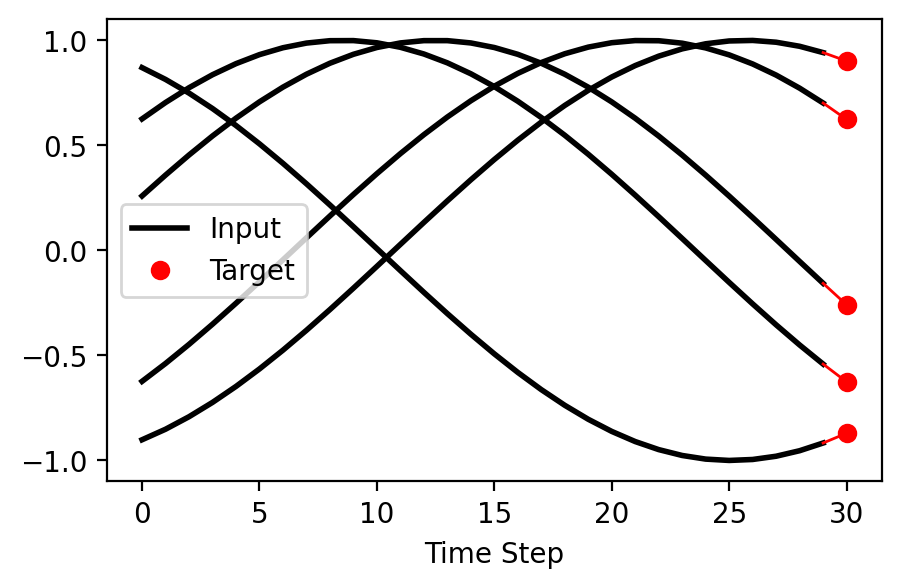

In [72]:
def sine_data(n, min_length, max_length, seed=1234):
    np.random.seed(seed)
    X, T, lengths = [], [], []
    for _ in range(n):
        seq_length = np.random.randint(min_length, max_length + 1)
        start = np.random.rand() * 2 * np.pi
        xs = np.linspace(start, start + (seq_length / max_length) * 1 * np.pi, seq_length + 1)
        t = np.sin(xs)
        x_padded = np.pad(t[:-1], (0, max_length - seq_length), 'constant')
        X.append(x_padded)          # input - all but last value, with padding (if needed)
        T.append(t[-1])             # target - only the last value
        lengths.append(seq_length)  # store the true sequence length
    return np.expand_dims(X, axis=-1), np.expand_dims(T, axis=-1), lengths

# generate data 
min_length = 30
max_length = min_length
n = 200 # number of samples

X, T, lengths = sine_data(n, min_length, max_length, seed=6)
print(f'{X.shape=}, {T.shape=}')

# !plotting
plt.figure(figsize=(5, 3))
for i in range(5):
    pre_pad_len = lengths[i]
    plt.plot(range(pre_pad_len), X[i, :pre_pad_len, 0], color='k', label='Input' if i == 0 else '', lw=2)
    plt.plot(pre_pad_len, T[i], 'ro', label='Target' if i == 0 else '')
    plt.plot([pre_pad_len - 1, pre_pad_len], [X[i, pre_pad_len-1, 0], T[i, 0]], ls='solid', color='r', lw=1)
plt.xlabel('Time Step')
plt.legend(loc='center left')
plt.show()

The figure above shows a few of the input-target samples. Notice, that we are sequentially processing the input to predict **only the next step** target. 

Now, implementing our `RNN` class in PyTorch...

In [73]:
class RNN(nn.Module):
    def __init__(self, 
                 n_inputs: int,
                 n_hiddens: int,
                 n_outputs: int,
                 n_layers: int = 1,
                 rnn_type: str = 'lstm'
        ):
        super().__init__()
        self.n_layers = n_layers
        self.n_hiddens = n_hiddens

        if rnn_type.lower() == 'lstm':
            self.rnn = nn.LSTM(n_inputs, n_hiddens, n_layers, batch_first=True)
        else:
            self.rnn = nn.RNN(n_inputs, n_hiddens, n_layers, batch_first=True)

        self.fc = nn.Linear(n_hiddens, n_outputs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # initial hidden state for the first step
        h0 = torch.zeros(self.n_layers, x.size(0), self.n_hiddens).to(x.device)

        if isinstance(self.rnn, nn.LSTM):
            c0 = torch.zeros(self.n_layers, x.size(0), self.n_hiddens).to(x.device)
            out, _ = self.rnn(x, (h0, c0))
        else:
            out, _ = self.rnn(x, h0)

        return self.fc(out[:, -1, :])

The recurrent looping occurs within the [`nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) or [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) layer. We now only need to define our network and pass it into the `NeuralNetwork` class for training.

In [74]:
torch.manual_seed(42)

dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                        torch.tensor(T, dtype=torch.float32))
train_data = DataLoader(dataset, batch_size=32, shuffle=True)

n_inputs = X.shape[2]
n_hiddens = 20
n_outputs = 1
n_layers = 2
rnn_type = 'lstm'

model = RNN(n_inputs, n_hiddens, n_outputs, n_layers, rnn_type)

epochs = 20
eta = 0.001

optimizer = torch.optim.AdamW(model.parameters(), lr=eta)
loss_fn = nn.MSELoss()

nent = NeuralNetwork(model, optimizer, loss_fn, use_gpu=True)
nent.train(train_data, epochs=epochs)

Using device: mps
Epoch 1/20 - Train Loss: 0.5366 - Time: 5.59s
Epoch 5/20 - Train Loss: 0.3926 - Time: 0.38s
Epoch 9/20 - Train Loss: 0.1695 - Time: 0.41s
Epoch 13/20 - Train Loss: 0.0192 - Time: 0.42s
Epoch 17/20 - Train Loss: 0.0032 - Time: 0.42s
Finished in 12.55s


We overfit to the training data (loss of 0.0)! But, this is okay because our output sequence is identical to what we are training on. 

In this example, we won't use the `use` function of our `NeuralNetwork` class. Instead, we define the `use_rnn` function to generate samples *autoregressively*, i.e., iteratively using the output as the next state. With this, we can predict for as far out into the future as we would like (as our model will allow for us to, accurately).

The input to our model is similar to that of the training data -- a window of a sine wave with a period of $\pi$ and randomly phase shifted between $[0, 2\pi]$.

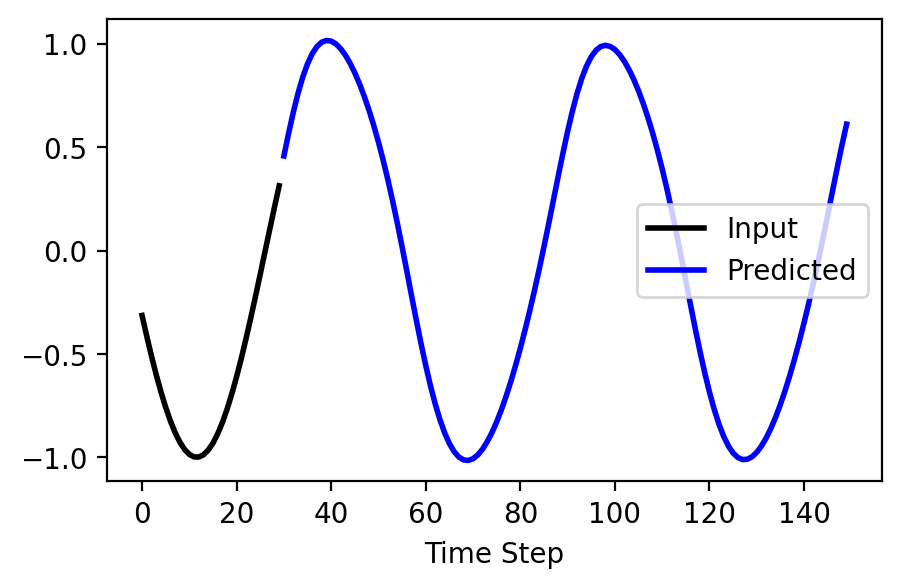

In [75]:
def use_rnn(model, steps, seq_length, max_length, device, seed=1234):
    np.random.seed(seed)
    model.eval()

    start = np.random.rand() * 2 * np.pi
    xs = np.linspace(start, start + (seq_length / max_length) * 1 * np.pi, seq_length)
    trace = np.sin(xs).tolist()

    x = torch.tensor(trace, dtype=torch.float32).view(1, -1, 1).to(device)
    
    with torch.no_grad():
        for _ in range(steps):
            yi = model(x)
            trace.append(yi.item())

            # update the input tensor by appending the new prediction
            x = torch.cat([x, yi.view(1, 1, 1)], dim=1).to(device)
            if x.size(1) > max_length: # maintain a max context window
                x = x[:, -max_length:, :]

    return trace[:seq_length], trace[seq_length:]

seq_length = max_length
assert seq_length <= max_length and seq_length >= min_length

steps = 120  # number of steps to predict into the future

x, y = use_rnn(model, steps, seq_length, max_length, nnet.device, seed=3)

# !plotting
plt.figure(figsize=(5, 3))
plt.plot(x, label='Input', color='k', lw=2)
plt.plot(range(seq_length, seq_length + steps), y, label='Predicted', color='b', lw=2)
plt.xlabel('Time Step')
plt.legend(loc='center right')
plt.show()

Try changing the number of `steps` to see how far out into the future we can predict! 

### Transformers

Recurrent networks are great for handling sequential data, especially for simpler tasks. However, they are limited in their ability to capture long-range dependencies and are inefficienct for parallel processing.

This is where transformers come in! Introduced in the seminal paper [Attention is All you Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. 2017, this work has amassed over 129,000 citations as of this writing. The key innovation of transformers is *self-attention*, which allows the model to focus on different parts of the input sequence simultaneously, capturing both local and global dependencies effectively. {numref}`transformer-im` illustrates the transformer architecture, comprising an encoder to process the input sequence and a decoder to generate the output sequence.

:::{figure-md} transformer-im
<img src="../../img/machine-learning/transformer.png" alt="transformer-im" width="400px">

The Transformer (encoder + decoder) architecture ([Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762)).
:::

Transformers have made a large spash in both research and industry, dominating a wide range of tasks, from natural language processing to image analysis, achieving unprecedented success. The architecture is a bit more advance, and given the abundance of material online, we are leaving it out of this tutorial -- perhaps to be a topic of a future one.

:::{seealso}
Additional transformer references:
- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
:::